In [245]:
import numpy as np
import pandas as pd
import pickle
import os
import json

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import animation
import matplotlib.colors as mcolors

import matplotlib as mpl
#%matplotlib inline

import networkx as nx

In [246]:
var_names_subset = None # [0,1,4,7,8,11,15,108,109,114,115,118,120,123,124,126,127,129,130,132,133,136,139,144,147,216]
#var_names = [x for x in range(30)]
var_names = ['R0_Air_Temperature', 'R0_Discomfort_Level',
       'R0_Occupancy', 'R0_Air_CO2', 'R0_Air_Humidity', 'R1_Air_Temperature',
       'R1_Discomfort_Level', 'R1_Occupancy', 'R1_Air_CO2', 'R1_Air_Humidity',
       'C_Air_Temperature', 'C_Discomfort_Level', 'C_Occupancy', 'C_Air_CO2',
       'C_Air_Humidity', 'ahu0_AHU_Supply_Air_Temperature',
       'ahu0_AHU_Return_Air_Temperature', 'ahu0_AHU_Input_Air_Temperature',
       'ahu0_AHU_Exhaust_Air_Temperature',
       'ahu0_AHU_Supply_ColdWater_Temperature',
       'ahu0_AHU_Supply_HotWater_Temperature',
       'ahu0_AHU_Supply_ColdWater_Flow', 'ahu0_AHU_Supply_HotWater_Flow',
       'boiler0_Boiler_Supply_Heating_Power', 'boiler_Supply_1',
       'boiler_Return_1', 'boiler_Supply_2', 'boiler_Return_2',
       'chiller0_Chiller_Supply_Cooling_Power', 'out_Air_Temperature']
mapping =  {i: str(x) for i, x in enumerate(var_names)}
mappingR={k:v for v,k in mapping.items()}

FCG = nx.from_numpy_array(np.ones((len(var_names), len(var_names))))
FCG = nx.relabel_nodes(FCG, mapping)

In [247]:
correctmappingInOut = [
    ('ahu0_AHU_Input_Air_Temperature','ahu0_AHU_Supply_Air_Temperature'),
    ('ahu0_AHU_Return_Air_Temperature','ahu0_AHU_Supply_Air_Temperature'),
    ('ahu0_AHU_Return_Air_Temperature','ahu0_AHU_Exhaust_Air_Temperature'),

    ('ahu0_AHU_Supply_ColdWater_Flow','ahu0_AHU_Supply_Air_Temperature'),
    ('ahu0_AHU_Supply_ColdWater_Temperature','ahu0_AHU_Supply_Air_Temperature'),
    ('ahu0_AHU_Supply_HotWater_Flow','ahu0_AHU_Supply_Air_Temperature'),
    ('ahu0_AHU_Supply_HotWater_Temperature','ahu0_AHU_Supply_Air_Temperature'),

    ('boiler0_Boiler_Supply_Heating_Power','ahu0_AHU_Supply_HotWater_Temperature'),
    ('boiler_Supply_1','ahu0_AHU_Supply_HotWater_Temperature'),
    ('boiler_Return_1','boiler_Supply_1'),
    ('ahu0_AHU_Supply_HotWater_Temperature','boiler_Return_1'),
    ('boiler_Supply_2','ahu0_AHU_Supply_HotWater_Temperature'),
    ('boiler_Return_2','boiler_Supply_2'),
    ('ahu0_AHU_Supply_HotWater_Temperature','boiler_Return_2'),

    ('chiller0_Chiller_Supply_Cooling_Power','ahu0_AHU_Supply_Air_Temperature'),

    ('R0_Air_Temperature','R0_Discomfort_Level'),
    ('out_Air_Temperature','R0_Air_Temperature'),
    ('R0_Occupancy','R0_Air_Temperature'),
    ('R0_Occupancy','R0_Air_CO2'),
    ('R0_Occupancy','R0_Air_Humidity'),
    ('R0_Air_Temperature','ahu0_AHU_Return_Air_Temperature'),
    ('ahu0_AHU_Supply_Air_Temperature','R0_Air_Temperature'),

    ('R1_Air_Temperature','R1_Discomfort_Level'),
    ('out_Air_Temperature','R1_Air_Temperature'),
    ('R1_Occupancy','R1_Air_Temperature'),
    ('R1_Occupancy','R1_Air_CO2'),
    ('R1_Occupancy','R1_Air_Humidity'),
    ('R1_Air_Temperature','ahu0_AHU_Return_Air_Temperature'),
    ('ahu0_AHU_Supply_Air_Temperature','R1_Air_Temperature'),

    ('C_Air_Temperature','C_Discomfort_Level'),
    ('out_Air_Temperature','C_Air_Temperature'),
    ('C_Occupancy','C_Air_Temperature'),
    ('C_Occupancy','C_Air_CO2'),
    ('C_Occupancy','C_Air_Humidity'),
    ('C_Air_Temperature','ahu0_AHU_Return_Air_Temperature'),
    ('ahu0_AHU_Supply_Air_Temperature','C_Air_Temperature'),

    ('R0_Air_Temperature','R1_Air_Temperature'),
    ('R1_Air_Temperature','R0_Air_Temperature'),
    ('C_Air_Temperature','R0_Air_Temperature'),
    ('C_Air_Temperature','R1_Air_Temperature'),
    ('R0_Air_Temperature','C_Air_Temperature'),
    ('R1_Air_Temperature','C_Air_Temperature'),

    ('C_Air_CO2','R0_Air_CO2'),
    ('C_Air_CO2','R1_Air_CO2'),
    ('R0_Air_CO2','C_Air_CO2'),
    ('R1_Air_CO2','C_Air_CO2'),

    ('C_Air_Humidity','R0_Air_Humidity'),
    ('C_Air_Humidity','R1_Air_Humidity'),
    ('R0_Air_Humidity','C_Air_Humidity'),
    ('R1_Air_Humidity','C_Air_Humidity'),
]

In [248]:
correctmapping=np.zeros((30,30))

for i,o in correctmappingInOut:
    correctmapping[mappingR[i],mappingR[o]]=1

GN = nx.from_numpy_array(correctmapping,create_using=nx.DiGraph)
GN = nx.relabel_nodes(GN, mapping)
GN.name="Ground Truth"

print(f"Graph density: {nx.density(GN)}")
print(f"Number of edges: {len(GN.edges)}")

np.save("Graphs/CorrectMapping.npy", correctmapping)

np.save("Graphs/Ones.npy", np.ones((30,30)))
np.save("Graphs/Zeros.npy", np.zeros((30,30)))

Graph density: 0.05747126436781609
Number of edges: 50


In [249]:
# graph of all nodes max 2 hops away
GN2=nx.DiGraph(name="Ground Truth 2 Hops")
GN2.add_nodes_from(GN)
# graph of all nodes max 3 hops away
GN3=nx.DiGraph(name="Ground Truth 3 Hops")
GN3.add_nodes_from(GN)

for s,p in dict(nx.shortest_path_length(GN)).items():
    for t,d in p.items():
        if d>0 and d<3:
            GN2.add_edge(s,t)
        if d>0 and d<4:
            GN3.add_edge(s,t)

print(f"GN2 Graph density: {nx.density(GN2)}")
print(f"GN2 Number of edges: {len(GN2.edges)}")

print(f"GN3 Graph density: {nx.density(GN3)}")
print(f"GN3 Number of edges: {len(GN3.edges)}")

GN2 Graph density: 0.1471264367816092
GN2 Number of edges: 128
GN3 Graph density: 0.21954022988505748
GN3 Number of edges: 191


In [250]:
if not os.path.exists("Graphs/layout.pkl"):
    pos = nx.spring_layout(GN.to_undirected(), iterations=100, seed=12)
    #pos = nx.kamada_kawai_layout(GN.to_undirected())
    #pos = nx.shell_layout(GN.to_undirected())
    with open("Graphs/layout.pkl","bw") as fo:
        pickle.dump(pos,fo)
else:
    with open("Graphs/layout.pkl","br") as fi:
        pos=pickle.load(fi)

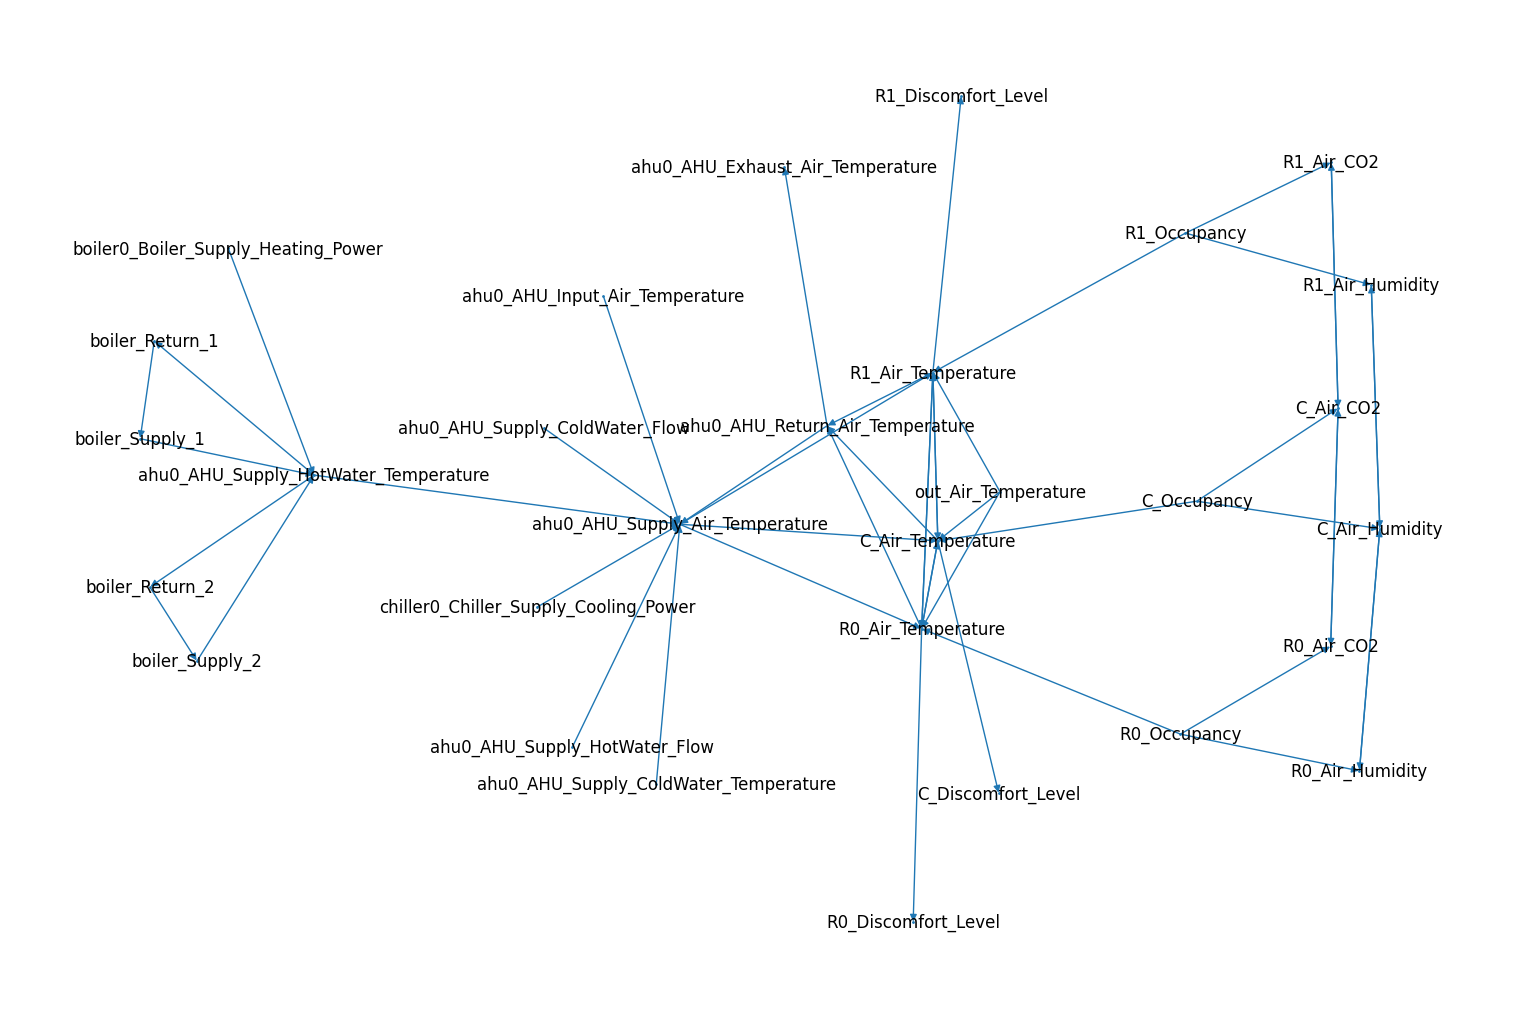

In [302]:
plt.figure(1, figsize=(15,10))
nx.draw(GN, node_size=1, edge_color="tab:blue", pos=pos, with_labels=True, arrows=True)
#nx.draw(GN, node_size=10, edge_color="tab:blue", pos=pos)
plt.savefig("Plots/GroundTruth.png")

In [252]:
plt.figure(1, figsize=(15,10))
nx.draw(GN2, node_size=1, edge_color="tab:blue", pos=pos, with_labels=True, arrows=True)

In [253]:
plt.figure(1, figsize=(15,10))
nx.draw(GN3, node_size=1, edge_color="tab:blue", pos=pos, with_labels=True, arrows=True)

In [254]:
#plt.figure(1, figsize=(15,10))
#pos2 = nx.spring_layout(GN2.to_undirected(), iterations=100, seed=12, scale=20)
#nx.draw(GN3, node_size=1, edge_color="tab:blue", pos=pos2, with_labels=True, arrows=True)

In [255]:
def load_graph(fn, name=None, bidirectional=False):
    adj = np.load(fn)
    if bidirectional:
        adj = (adj + adj.T >= 1)
    adj = adj - np.eye(adj.shape[0])
    adj[adj < 1] = 0

    G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
    G = nx.relabel_nodes(G, mapping)
    G.name=name if name else fn
    return G

In [256]:
cluster_to_color = {i:c for i,c in enumerate(mcolors.TABLEAU_COLORS)}

In [257]:
def load_graph_stats(fn, name=None, bidirectional=False):
     with open(fn,"tr") as fi:
        stats=json.load(fi)
        adj=np.matrix(stats['adj_normalize'])
        if bidirectional:
            adj = (adj + adj.T >= 1)
        adj = adj - np.eye(adj.shape[0])
        adj[adj < 1] = 0

        cmap={}
        if 'clusters' in stats:
            for c, vv in stats['clusters'].items():
                for v in vv: cmap[v]=int(c)

        G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
        if cmap:
            for i in G.nodes:
                G.nodes[i]['cluster']=cmap[i]
                G.nodes[i]['color']=cluster_to_color[cmap[i]]

        G = nx.relabel_nodes(G, mapping)

        G.name=name if name else fn
        return G, adj

In [258]:
def compare(G, GN):
    TP = len(nx.intersection(G, GN).edges)
    FP = len(nx.difference(G, GN).edges)
    FN = len(nx.difference(GN, G).edges)
    TN = len(nx.intersection(nx.difference(FCG, G), nx.difference(FCG, GN)).edges)
    return {
        "name":G.name,
        "Density":nx.density(G),
        "Pdensity":nx.density(GN),
        "Edges":len(G.edges),
        "P":len(GN.edges),
        "N":len(nx.difference(FCG, GN).edges),
        "TP":TP,
        "FP":FP,
        "FN":FN,
        "TN":TN,
        "TPR":TP/(TP+FN),
        "TNR":TN/(TN+FP),
        "PPV":TP/(TP+FP),
        "ACC":(TP+TN)/(TP+TN+FP+FN),
        "F1":(2*TP)/(2*TP+FP+FN),
    }

In [310]:
def compare_plot(G, GN, saveto=None):
    TP = nx.intersection(G, GN)
    FP = nx.difference(G, GN)
    FN = nx.difference(GN, G)

    ns=100
    plt.figure(figsize=(20,10))
    plt.box(False)
    if 'color' in G.nodes['R0_Air_Temperature']:
        nx.draw_networkx_nodes(G, node_size=ns, node_color=[G.nodes[n]['color'] for n in G.nodes], pos=pos)
    else:
        nx.draw_networkx_nodes(G, node_size=ns, pos=pos)
    nx.draw_networkx_labels(G, pos=pos)
    nx.draw_networkx_edges(FP, node_size=ns, edge_color="tab:red", pos=pos)
    nx.draw_networkx_edges(FN, node_size=ns, edge_color="tab:orange", pos=pos)
    nx.draw_networkx_edges(TP, node_size=ns, edge_color="tab:blue", pos=pos)

    plt.legend(handles=[
            Line2D([0], [0], color='blue', label='TP'),
            Line2D([0], [0], color='red', label='FP'),
            Line2D([0], [0], color='orange', label='FN')
    ], loc='lower right', ncols=3)
    plt.title(f"{G.name} vs {GN.name}", fontweight="bold")
    if saveto:
        plt.savefig(saveto)

## Direct Graph

In [312]:
GD=load_graph('Graphs/Unclustered/PCMCI+_GPDC_30_288_45min_1.npy', 'Full 45min Day 1')

compare_plot(GD, GN)
compare(GD, GN)

{'name': 'Full 45min Day 1',
 'Density': 0.1724137931034483,
 'Pdensity': 0.05747126436781609,
 'Edges': 150,
 'P': 50,
 'N': 443,
 'TP': 9,
 'FP': 141,
 'FN': 41,
 'TN': 372,
 'TPR': 0.18,
 'TNR': 0.7251461988304093,
 'PPV': 0.06,
 'ACC': 0.6767317939609236,
 'F1': 0.09}

{'name': 'Full 45min Day 1',
 'Density': 0.1724137931034483,
 'Pdensity': 0.1471264367816092,
 'Edges': 150,
 'P': 128,
 'N': 414,
 'TP': 20,
 'FP': 130,
 'FN': 108,
 'TN': 349,
 'TPR': 0.15625,
 'TNR': 0.7286012526096033,
 'PPV': 0.13333333333333333,
 'ACC': 0.6079077429983526,
 'F1': 0.14388489208633093}

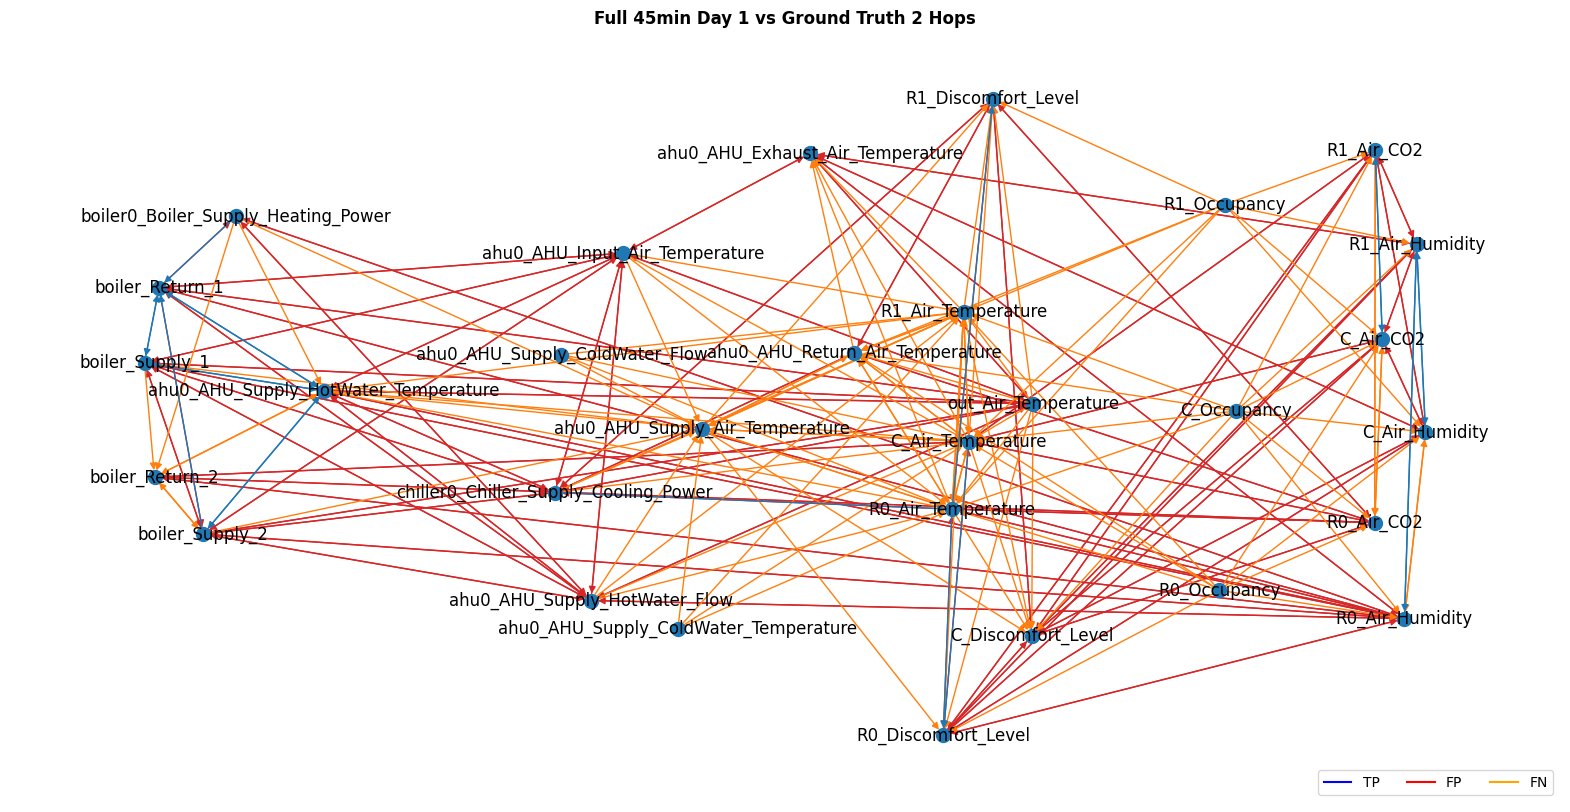

In [313]:
compare_plot(GD, GN2)
compare(GD, GN2)

{'name': 'Full 45min Day 1',
 'Density': 0.1724137931034483,
 'Pdensity': 0.21954022988505748,
 'Edges': 150,
 'P': 191,
 'N': 398,
 'TP': 26,
 'FP': 124,
 'FN': 165,
 'TN': 334,
 'TPR': 0.13612565445026178,
 'TNR': 0.7292576419213974,
 'PPV': 0.17333333333333334,
 'ACC': 0.5546995377503852,
 'F1': 0.15249266862170088}

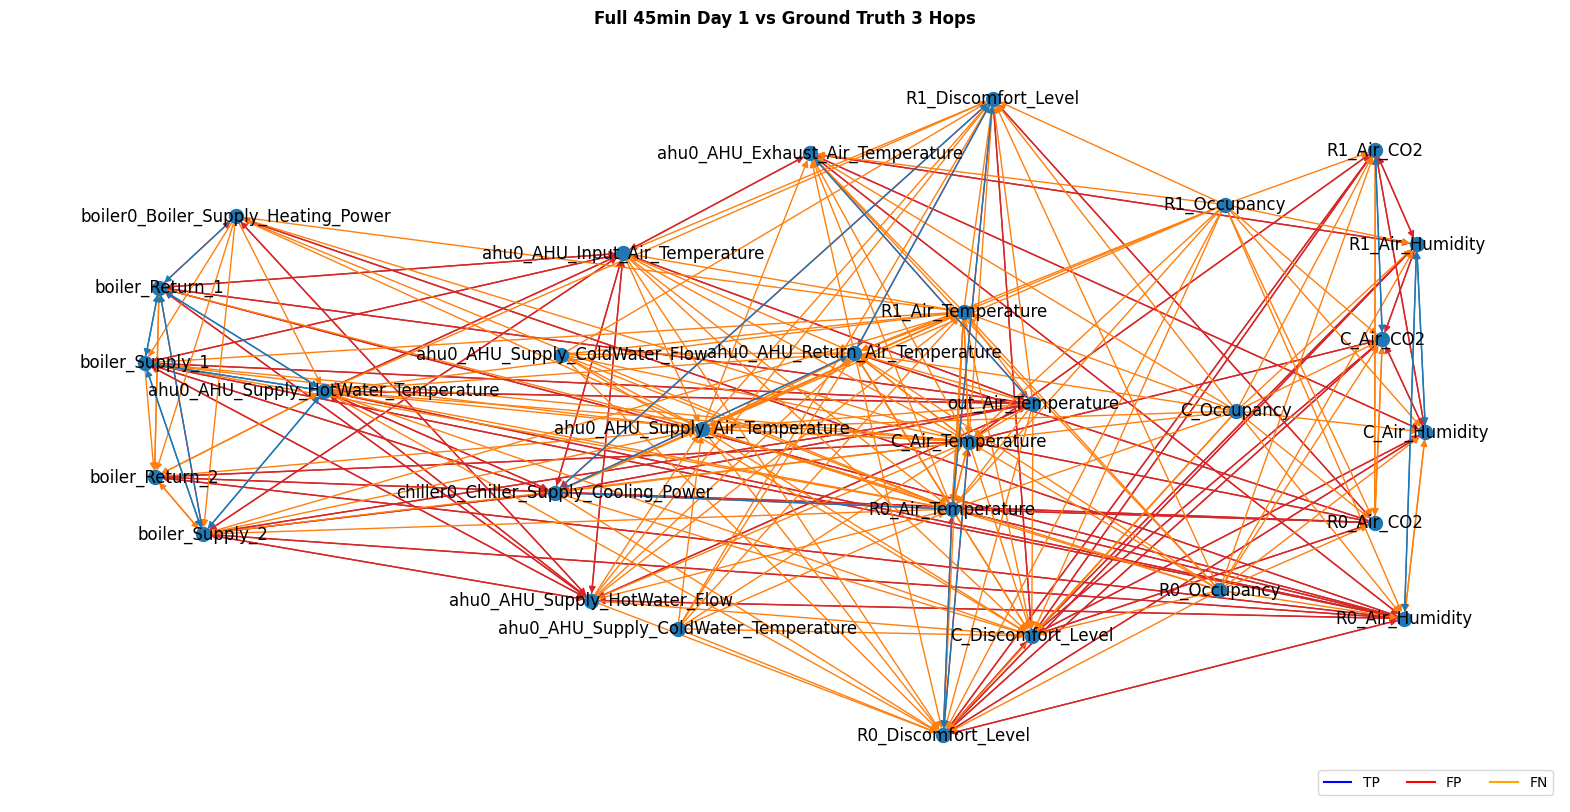

In [314]:
compare_plot(GD, GN3)
compare(GD, GN3)

## Clustered Graph

In [315]:
GC=load_graph('Graphs/Clustering/PCMCI+_GPDC_30_288_45min_1_10.npy', 'Clustered 5min Day 1')

compare_plot(GC, GN)
compare(GC, GN)

{'name': 'Clustered 5min Day 1',
 'Density': 0.04827586206896552,
 'Pdensity': 0.05747126436781609,
 'Edges': 42,
 'P': 50,
 'N': 443,
 'TP': 10,
 'FP': 32,
 'FN': 40,
 'TN': 427,
 'TPR': 0.2,
 'TNR': 0.9302832244008714,
 'PPV': 0.23809523809523808,
 'ACC': 0.8585461689587426,
 'F1': 0.21739130434782608}

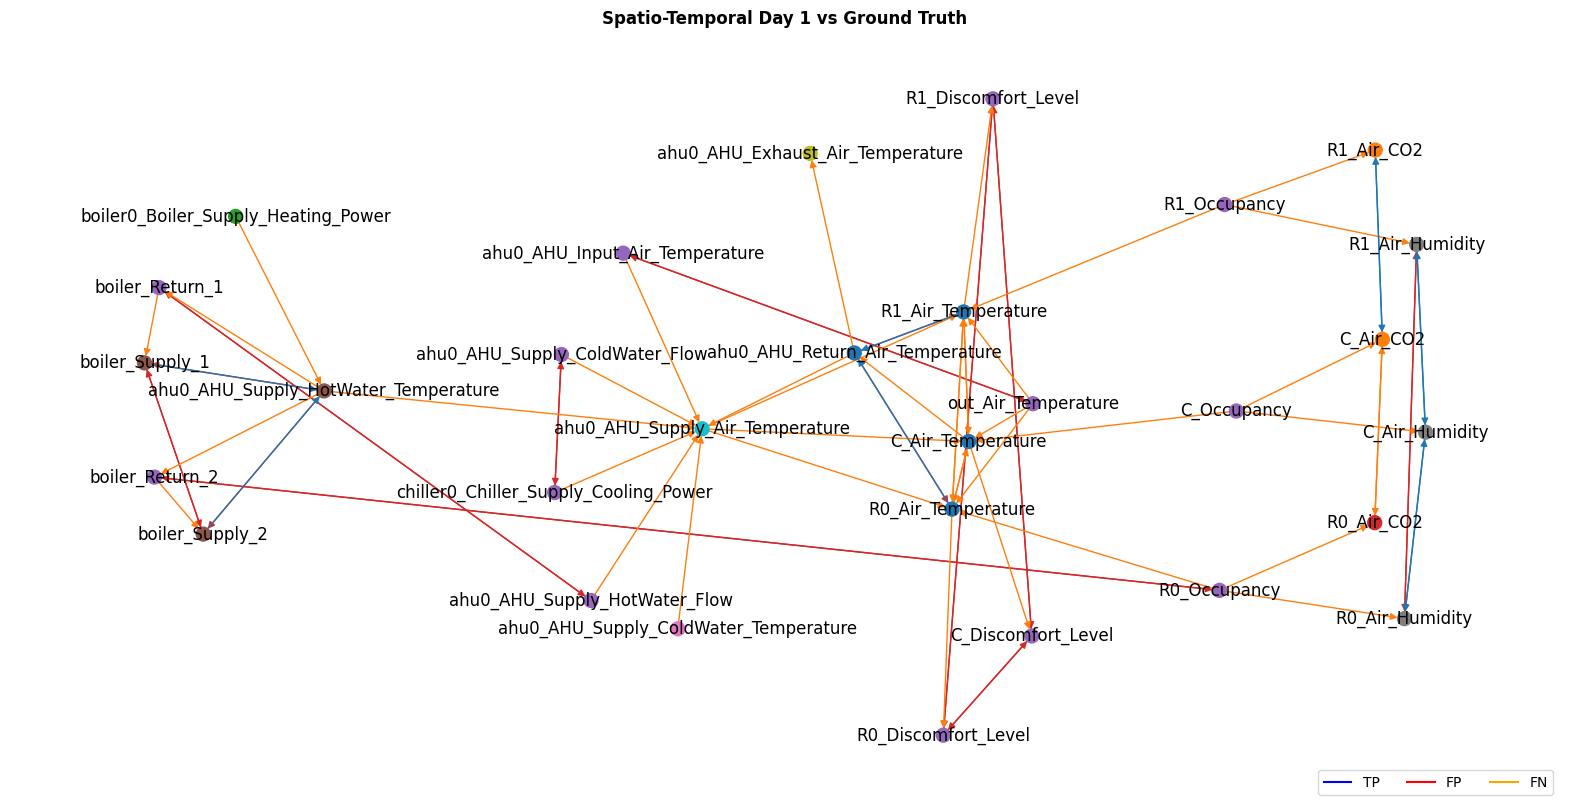

In [317]:
GD,_=load_graph_stats('Graphs/Clustering/PCMCI+_GPDC_30_144_6_1_10_stats.json', 'Spatio-Temporal Day 1')

compare_plot(GD, GN)
compare(GD, GN)
plt.savefig("Plots/SpatioTempD1.png")

In [265]:
compare_plot(GD, GN2)
compare(GD, GN2)

{'name': 'Clustered Day 1',
 'Density': 0.0367816091954023,
 'Pdensity': 0.1471264367816092,
 'Edges': 32,
 'P': 128,
 'N': 414,
 'TP': 16,
 'FP': 16,
 'FN': 112,
 'TN': 406,
 'TPR': 0.125,
 'TNR': 0.9620853080568721,
 'PPV': 0.5,
 'ACC': 0.7672727272727272,
 'F1': 0.2}

{'name': 'Clustered Day 1',
 'Density': 0.0367816091954023,
 'Pdensity': 0.21954022988505748,
 'Edges': 32,
 'P': 191,
 'N': 398,
 'TP': 18,
 'FP': 14,
 'FN': 173,
 'TN': 391,
 'TPR': 0.09424083769633508,
 'TNR': 0.9654320987654321,
 'PPV': 0.5625,
 'ACC': 0.6862416107382551,
 'F1': 0.16143497757847533}

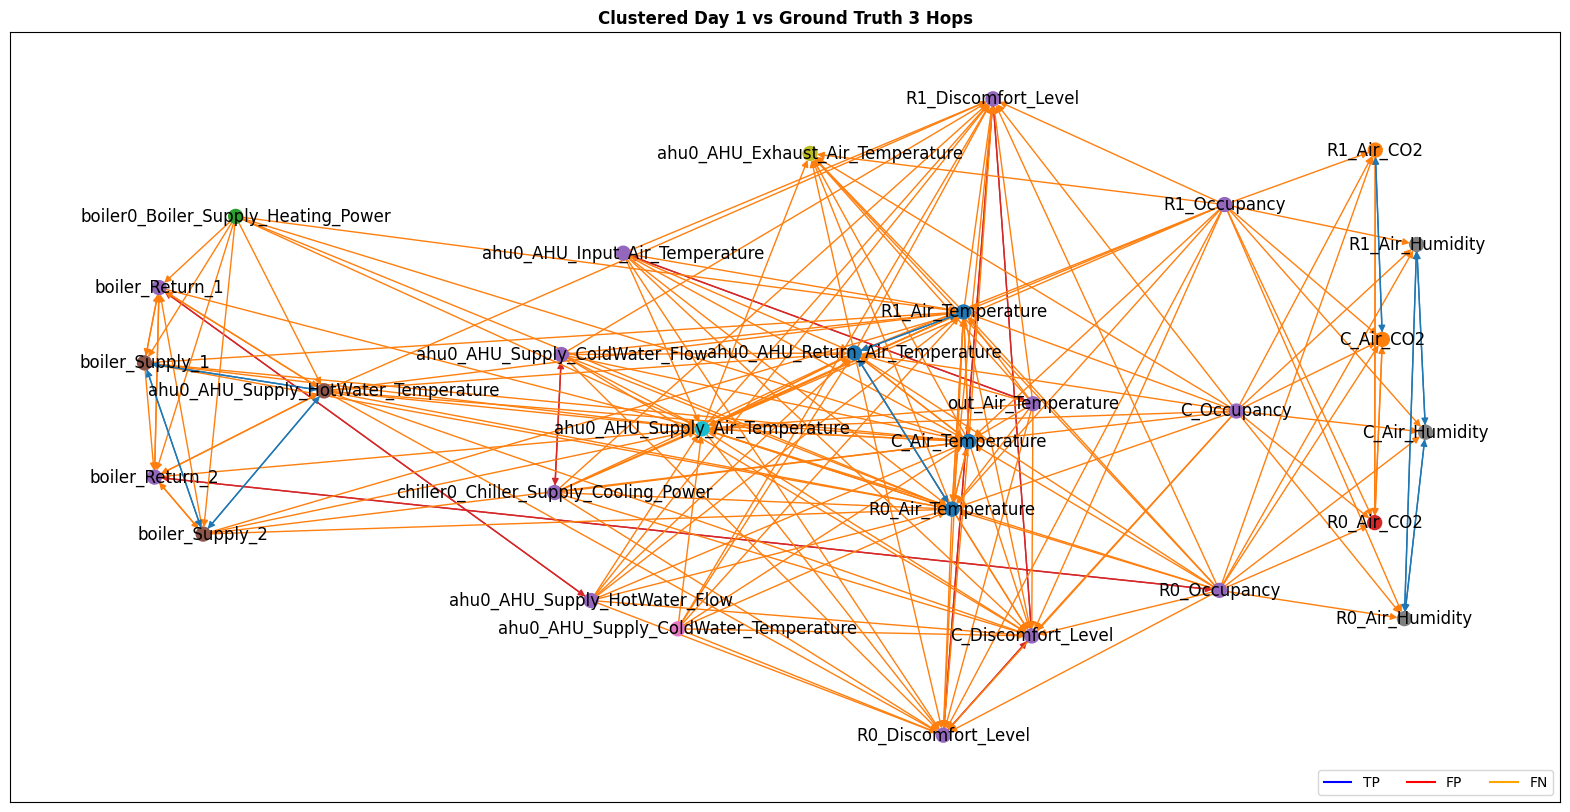

In [266]:
compare_plot(GD, GN3)
compare(GD, GN3)

## Clustered vs Direct

{'name': 'Clustered 5min Day 1',
 'Density': 0.04827586206896552,
 'Pdensity': 0.0367816091954023,
 'Edges': 42,
 'P': 32,
 'N': 449,
 'TP': 26,
 'FP': 16,
 'FN': 6,
 'TN': 441,
 'TPR': 0.8125,
 'TNR': 0.9649890590809628,
 'PPV': 0.6190476190476191,
 'ACC': 0.9550102249488752,
 'F1': 0.7027027027027027}

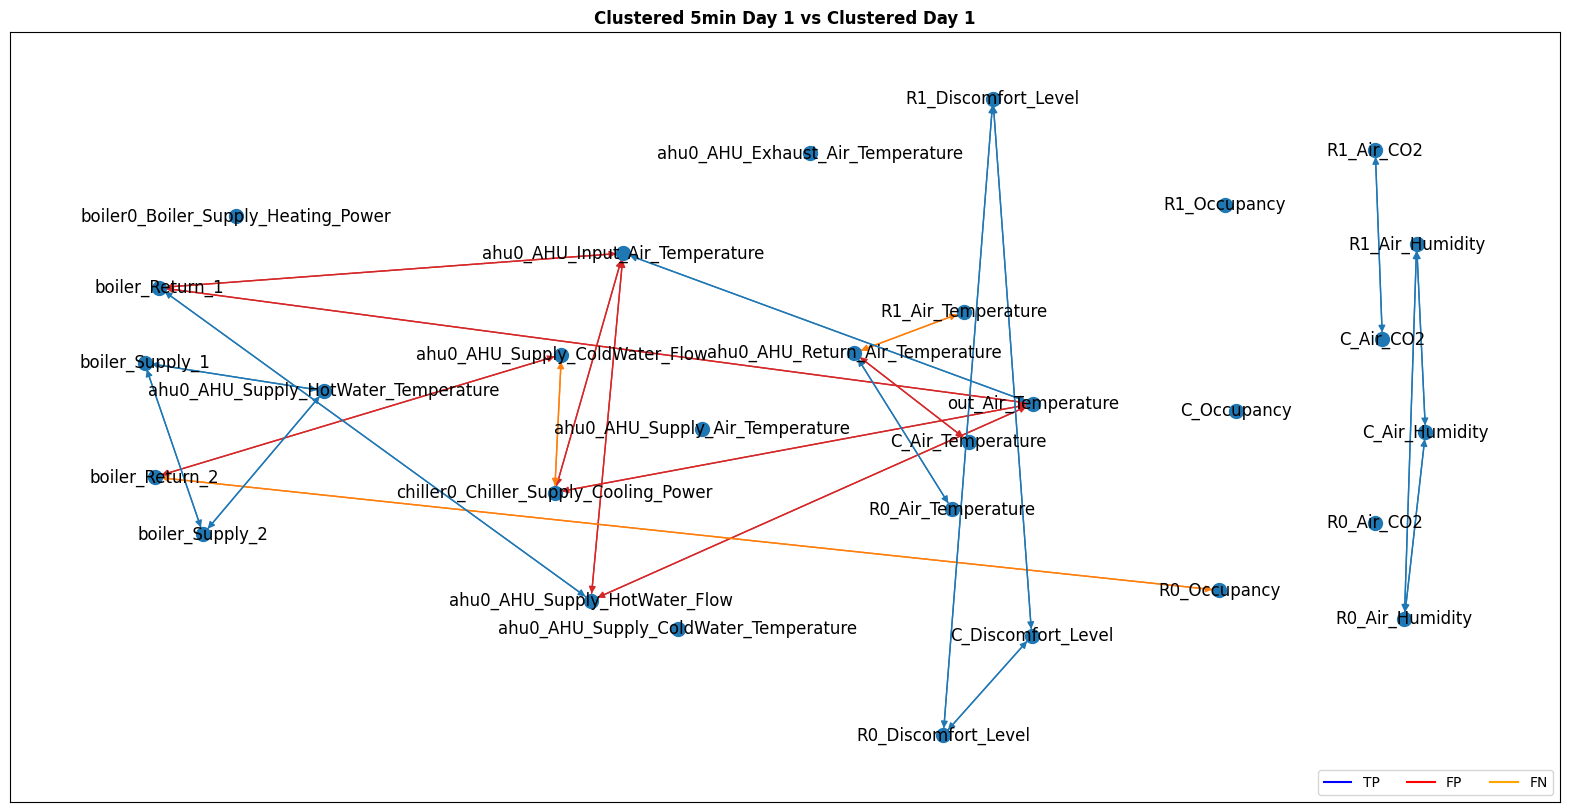

In [267]:
compare_plot(GC, GD)
compare(GC, GD)

## Clustered Multi

In [268]:
G_last=None
compGN=[]
compPrev=[]
adj_total=np.zeros((30,30))
cnt=0
for i in range(1,365):
    fn=f"Graphs/Clustering/PCMCI+_GPDC_30_144_6_{i}_10_stats.json"
    if os.path.exists(fn):
        cnt+=1
        G,adj=load_graph_stats(fn, f"Clustering Day {i}")
        adj_total=adj_total+adj
        compGN.append(compare(G,GN))
        #compare_plot(G,GN,f"Plots/PCMCI+_GPDC_30_144_6_{i}_10.png")
        if G_last:
            compPrev.append(compare(G,G_last))
        G_last=G

In [269]:
compGNdf=pd.DataFrame(compGN)
compGNdf

name   Density  Pdensity  Edges   P    N  TP  FP  FN   TN  \
0      Clustering Day 1  0.036782  0.057471     32  50  443  10  22  40  432   
1      Clustering Day 2  0.034483  0.057471     30  50  443  13  17  37  434   
2      Clustering Day 3  0.032184  0.057471     28  50  443  11  17  39  434   
3      Clustering Day 4  0.029885  0.057471     26  50  443   9  17  41  434   
4      Clustering Day 5  0.027586  0.057471     24  50  443   6  18  44  433   
..                  ...       ...       ...    ...  ..  ...  ..  ..  ..  ...   
358  Clustering Day 360  0.022989  0.057471     20  50  443   7  13  43  436   
359  Clustering Day 361  0.029885  0.057471     26  50  443   8  18  42  434   
360  Clustering Day 362  0.025287  0.057471     22  50  443   7  15  43  435   
361  Clustering Day 363  0.029885  0.057471     26  50  443   7  19  43  433   
362  Clustering Day 364  0.032184  0.057471     28  50  443  11  17  39  434   

      TPR       TNR       PPV       ACC        F1  
0    0.20  0.951542  0.312500  0.876984  0.243902  
1    0.26  0.962306  0.433333  0.892216  0.325000  
2    0.22  0.962306  0.392857  0.888224  0.282051  
3    0.18  0.962306  0.346154  0.884232  0.236842  
4    0.12  0.960089  0.250000  0.876248  0.162162  
..    ...       ...       ...       ...       ...  
358  0.14  0.971047  0.350000  0.887776  0.200000  
359  0.16  0.960177  0.307692  0.880478  0.210526  
360  0.14  0.966667  0.318182  0.884000  0.194444  
361  0.14  0.957965  0.269231  0.876494  0.184211  
362  0.22  0.962306  0.392857  0.888224  0.282051  

[363 rows x 15 columns]

<AxesSubplot: >

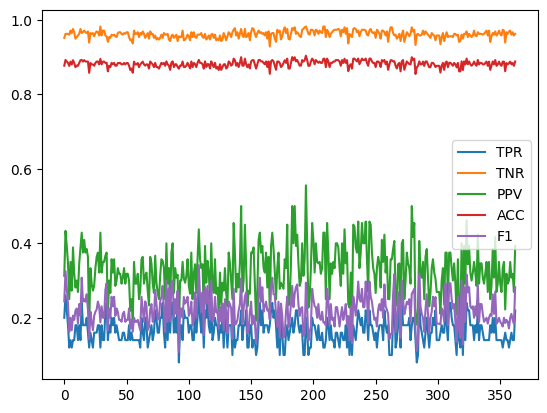

In [270]:
compGNdf[['TPR',"TNR","PPV","ACC","F1"]].plot()

In [271]:
compGNdf.describe()

Density    Pdensity       Edges      P      N          TP  \
count  363.000000  363.000000  363.000000  363.0  363.0  363.000000   
mean     0.029784    0.057471   25.911846   50.0  443.0    8.360882   
std      0.005886    0.000000    5.120962    0.0    0.0    1.821999   
min      0.016092    0.057471   14.000000   50.0  443.0    4.000000   
25%      0.025287    0.057471   22.000000   50.0  443.0    7.000000   
50%      0.029885    0.057471   26.000000   50.0  443.0    8.000000   
75%      0.034483    0.057471   30.000000   50.0  443.0    9.000000   
max      0.048276    0.057471   42.000000   50.0  443.0   14.000000   

               FP          FN          TN         TPR         TNR         PPV  \
count  363.000000  363.000000  363.000000  363.000000  363.000000  363.000000   
mean    17.550964   41.639118  434.264463    0.167218    0.961200    0.328146   
std      4.465895    1.821999    2.382378    0.036440    0.009681    0.065665   
min      8.000000   36.000000  427.000000    0.080000    0.928261    0.166667   
25%     15.000000   41.000000  433.000000    0.140000    0.955850    0.285714   
50%     17.000000   42.000000  434.000000    0.160000    0.962306    0.333333   
75%     20.000000   43.000000  436.000000    0.180000    0.966741    0.375000   
max     33.000000   46.000000  440.000000    0.280000    0.982143    0.555556   

              ACC          F1  
count  363.000000  363.000000  
mean     0.882080    0.219575  
std      0.008509    0.042076  
min      0.854617    0.108108  
25%      0.876740    0.189189  
50%      0.884000    0.216216  
75%      0.888224    0.243902  
max      0.903614    0.341463

In [272]:
compPrevDF=pd.DataFrame(compPrev)
compPrevDF

name   Density  Pdensity  Edges   P    N  TP  FP  FN   TN  \
0      Clustering Day 2  0.034483  0.036782     30  32  449  26   4   6  447   
1      Clustering Day 3  0.032184  0.034483     28  30  450  24   4   6  448   
2      Clustering Day 4  0.029885  0.032184     26  28  451  26   0   2  451   
3      Clustering Day 5  0.027586  0.029885     24  26  452  20   4   6  450   
4      Clustering Day 6  0.022989  0.027586     20  24  453  16   4   8  451   
..                  ...       ...       ...    ...  ..  ...  ..  ..  ..  ...   
357  Clustering Day 360  0.022989  0.022989     20  20  455  14   6   6  452   
358  Clustering Day 361  0.029885  0.022989     26  20  455  18   8   2  451   
359  Clustering Day 362  0.025287  0.029885     22  26  452  18   4   8  450   
360  Clustering Day 363  0.029885  0.025287     26  22  454  18   8   4  450   
361  Clustering Day 364  0.032184  0.029885     28  26  452  22   6   4  449   

          TPR       TNR       PPV       ACC        F1  
0    0.812500  0.991131  0.866667  0.979296  0.838710  
1    0.800000  0.991150  0.857143  0.979253  0.827586  
2    0.928571  1.000000  1.000000  0.995825  0.962963  
3    0.769231  0.991189  0.833333  0.979167  0.800000  
4    0.666667  0.991209  0.800000  0.974948  0.727273  
..        ...       ...       ...       ...       ...  
357  0.700000  0.986900  0.700000  0.974895  0.700000  
358  0.900000  0.982571  0.692308  0.979123  0.782609  
359  0.692308  0.991189  0.818182  0.975000  0.750000  
360  0.818182  0.982533  0.692308  0.975000  0.750000  
361  0.846154  0.986813  0.785714  0.979210  0.814815  

[362 rows x 15 columns]

In [273]:
compPrevDF.describe()

Density    Pdensity       Edges           P           N          TP  \
count  362.000000  362.000000  362.000000  362.000000  362.000000  362.000000   
mean     0.029764    0.029777   25.895028   25.906077  452.046961   18.955801   
std      0.005883    0.005893    5.118001    5.126869    2.563434    4.312352   
min      0.016092    0.016092   14.000000   14.000000  444.000000    8.000000   
25%      0.025287    0.025287   22.000000   22.000000  450.000000   16.000000   
50%      0.029885    0.029885   26.000000   26.000000  452.000000   20.000000   
75%      0.034483    0.034483   30.000000   30.000000  454.000000   22.000000   
max      0.048276    0.048276   42.000000   42.000000  458.000000   30.000000   

               FP          FN          TN         TPR         TNR         PPV  \
count  362.000000  362.000000  362.000000  362.000000  362.000000  362.000000   
mean     6.939227    6.950276  448.577348    0.741193    0.984828    0.741434   
std      4.505664    4.500879    2.947525    0.142304    0.009743    0.141878   
min      0.000000    0.000000  438.000000    0.380952    0.948608    0.333333   
25%      4.000000    4.000000  447.000000    0.642857    0.978214    0.643908   
50%      6.000000    6.000000  449.000000    0.750000    0.986784    0.750000   
75%     10.000000   10.000000  451.000000    0.846154    0.991209    0.833333   
max     24.000000   26.000000  456.000000    1.000000    1.000000    1.000000   

              ACC          F1  
count  362.000000  362.000000  
mean     0.971210    0.730950  
std      0.013185    0.115997  
min      0.922764    0.400000  
25%      0.962733    0.666667  
50%      0.974816    0.740741  
75%      0.979253    0.814815  
max      1.000000    1.000000

In [274]:
compPrevDF[['TPR',"TNR","PPV","ACC","F1"]].plot()

<AxesSubplot: >

In [275]:
adj_total_mv=np.where(adj_total/cnt>=0.5, 1, 0)

GMV = nx.from_numpy_array(adj_total_mv*adj_total, create_using=nx.DiGraph)
np.save("Graphs/ClusteredGMV_weighted.npy", GMV)

GMV = nx.from_numpy_array(adj_total_mv, create_using=nx.DiGraph)
np.save("Graphs/ClusteredGMV.npy", GMV)

GMV = nx.relabel_nodes(GMV, mapping)
GMV.name="Majority Vote"

compare_plot(GMV, GN)
compare(GMV, GN)

{'name': 'Majority Vote',
 'Density': 0.029885057471264367,
 'Pdensity': 0.05747126436781609,
 'Edges': 26,
 'P': 50,
 'N': 443,
 'TP': 10,
 'FP': 16,
 'FN': 40,
 'TN': 435,
 'TPR': 0.2,
 'TNR': 0.9645232815964523,
 'PPV': 0.38461538461538464,
 'ACC': 0.8882235528942116,
 'F1': 0.2631578947368421}

{'name': '1/3 Vote',
 'Density': 0.03218390804597701,
 'Pdensity': 0.05747126436781609,
 'Edges': 28,
 'P': 50,
 'N': 443,
 'TP': 10,
 'FP': 18,
 'FN': 40,
 'TN': 434,
 'TPR': 0.2,
 'TNR': 0.9601769911504425,
 'PPV': 0.35714285714285715,
 'ACC': 0.8844621513944223,
 'F1': 0.2564102564102564}

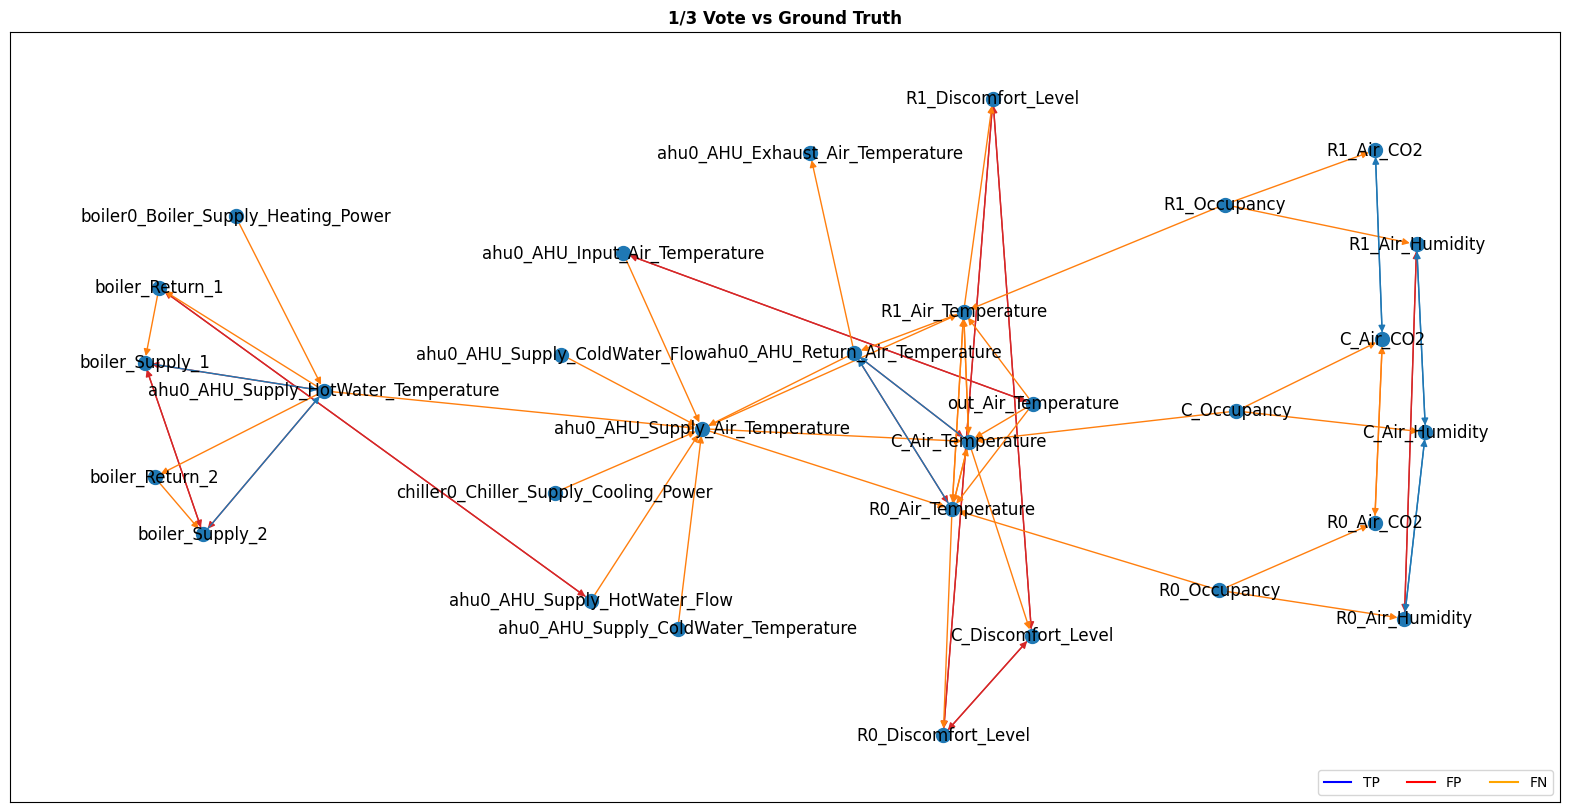

In [276]:
adj_total_mv33=np.where(adj_total/cnt>=1/3.0, 1, 0)

GMV33 = nx.from_numpy_array(adj_total_mv33*adj_total, create_using=nx.DiGraph)
np.save("Graphs/ClusteredGMV33_weighted.npy", GMV33)

GMV33 = nx.from_numpy_array(adj_total_mv33, create_using=nx.DiGraph)
np.save("Graphs/ClusteredGMV33.npy", GMV33)

GMV33 = nx.relabel_nodes(GMV33, mapping)
GMV33.name="1/3 Vote"

compare_plot(GMV33, GN)
compare(GMV33, GN)

{'name': 'Any',
 'Density': 0.03218390804597701,
 'Pdensity': 0.05747126436781609,
 'Edges': 28,
 'P': 50,
 'N': 443,
 'TP': 11,
 'FP': 17,
 'FN': 39,
 'TN': 434,
 'TPR': 0.22,
 'TNR': 0.9623059866962306,
 'PPV': 0.39285714285714285,
 'ACC': 0.8882235528942116,
 'F1': 0.28205128205128205}

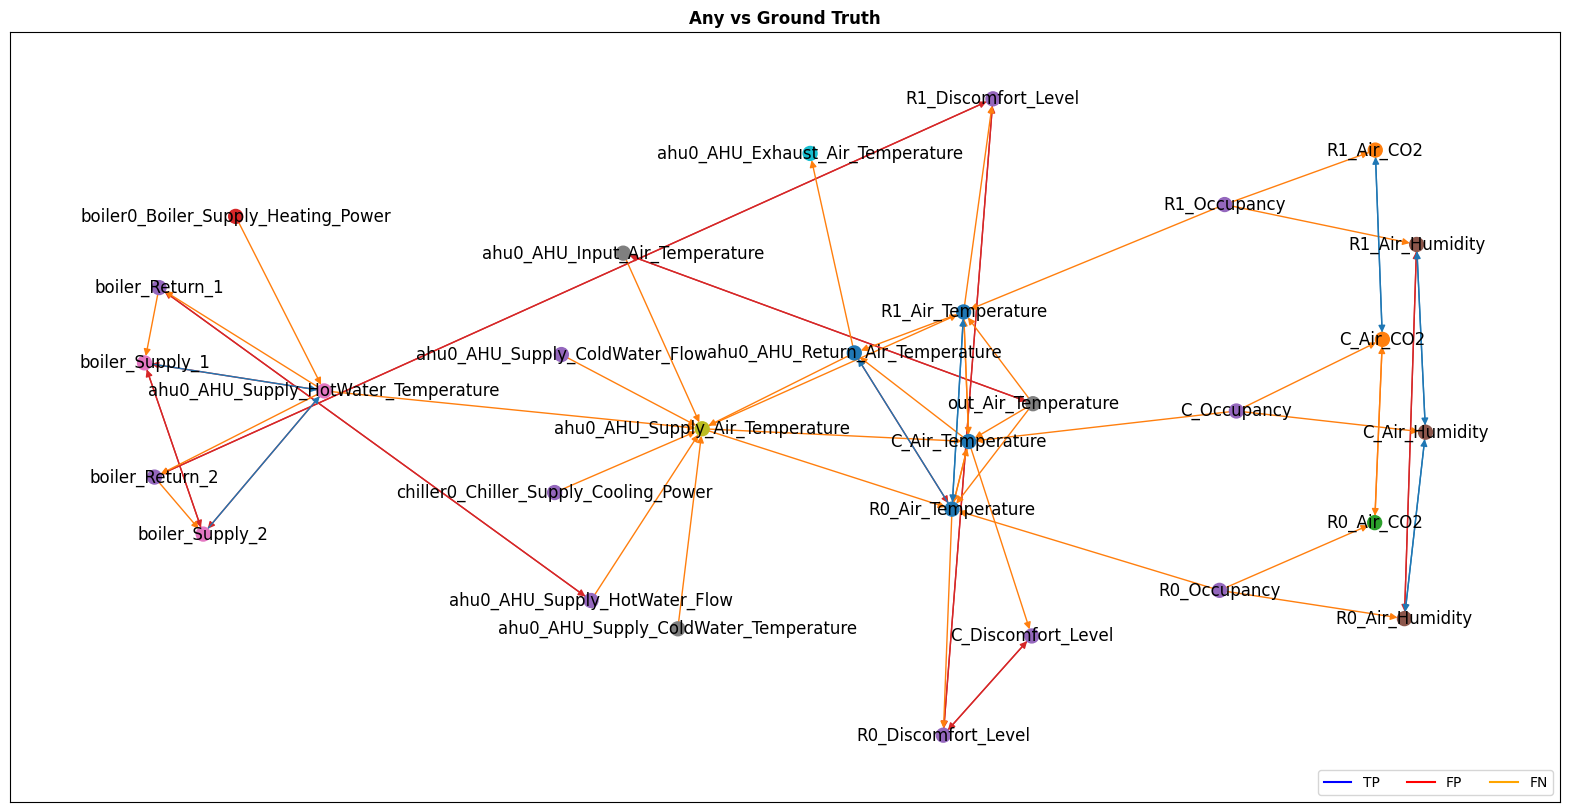

In [277]:
adj_total_any=np.where(adj_total>0, 1, 0)

GTA = nx.from_numpy_array(adj_total_any*adj_total, create_using=nx.DiGraph)
np.save("Graphs/ClusteredGTA_weighted.npy", GTA)

GTA = nx.from_numpy_array(adj_total_any, create_using=nx.DiGraph)
np.save("Graphs/ClusteredGTA.npy", GTA)

GTA = nx.relabel_nodes(G, mapping)
GTA.name="Any"

compare_plot(GTA, GN)
compare(GTA, GN)

## Unclustered

In [278]:
G_last=None
compGNU=[]
compPrevU=[]
adj_total=np.zeros((30,30))
cnt=0
for i in range(1,365):
    fn=f"Graphs/Unclustered/PCMCI+_GPDC_30_144_6_{i}_stats.json"
    if os.path.exists(fn):
        print(fn)
        cnt+=1
        G,adj=load_graph_stats(fn, f"Day {i}")
        adj_total=adj_total+adj
        compGNU.append(compare(G,GN))
        #compare_plot(G,GN,f"Plots/PCMCI+_GPDC_30_144_6_{i}_10.png")
        if G_last:
            compPrevU.append(compare(G,G_last))
        G_last=G

Graphs/Unclustered/PCMCI+_GPDC_30_144_6_1_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_2_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_3_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_4_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_5_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_6_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_7_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_8_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_9_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_10_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_11_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_12_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_13_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_14_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_15_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_16_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_17_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144_6_18_stats.json
Graphs/Unclustered/PCMCI+_GPDC_30_144

In [279]:
compGNUdf=pd.DataFrame(compGNU)
compGNUdf

name   Density  Pdensity  Edges   P    N  TP  FP  FN   TN   TPR  \
0    Day 1  0.048276  0.057471     42  50  443   6  36  44  424  0.12   
1    Day 2  0.043678  0.057471     38  50  443   7  31  43  427  0.14   
2    Day 3  0.045977  0.057471     40  50  443   6  34  44  425  0.12   
3    Day 4  0.050575  0.057471     44  50  443   8  36  42  425  0.16   
4    Day 5  0.055172  0.057471     48  50  443   7  41  43  422  0.14   
..     ...       ...       ...    ...  ..  ...  ..  ..  ..  ...   ...   
65  Day 66  0.057471  0.057471     50  50  443   9  41  41  422  0.18   
66  Day 67  0.064368  0.057471     56  50  443   9  47  41  419  0.18   
67  Day 68  0.050575  0.057471     44  50  443   7  37  43  424  0.14   
68  Day 69  0.062069  0.057471     54  50  443   9  45  41  421  0.18   
69  Day 70  0.052874  0.057471     46  50  443   6  40  44  423  0.12   

         TNR       PPV       ACC        F1  
0   0.921739  0.142857  0.843137  0.130435  
1   0.932314  0.184211  0.854331  0.159091  
2   0.925926  0.150000  0.846758  0.133333  
3   0.921909  0.181818  0.847358  0.170213  
4   0.911447  0.145833  0.836257  0.142857  
..       ...       ...       ...       ...  
65  0.911447  0.180000  0.840156  0.180000  
66  0.899142  0.160714  0.829457  0.169811  
67  0.919740  0.159091  0.843444  0.148936  
68  0.903433  0.166667  0.833333  0.173077  
69  0.913607  0.130435  0.836257  0.125000  

[70 rows x 15 columns]

<AxesSubplot: >

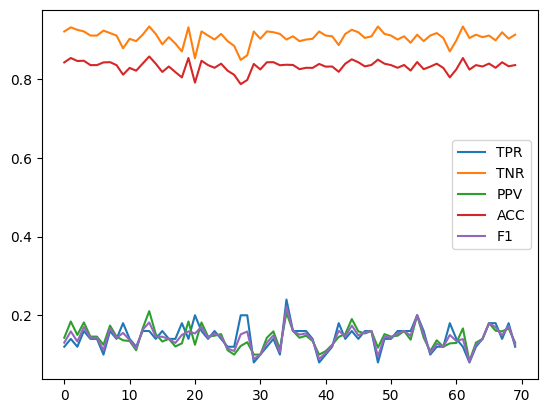

In [280]:
compGNUdf[['TPR',"TNR","PPV","ACC","F1"]].plot()

In [281]:
compGNUdf.describe()

Density      Pdensity      Edges     P      N        TP         FP  \
count  70.000000  7.000000e+01  70.000000  70.0   70.0  70.00000  70.000000   
mean    0.057931  5.747126e-02  50.400000  50.0  443.0   7.20000  43.200000   
std     0.010998  6.988995e-18   9.568063   0.0    0.0   1.57517   8.653725   
min     0.039080  5.747126e-02  34.000000  50.0  443.0   4.00000  30.000000   
25%     0.050575  5.747126e-02  44.000000  50.0  443.0   6.00000  38.000000   
50%     0.055172  5.747126e-02  48.000000  50.0  443.0   7.00000  41.000000   
75%     0.062069  5.747126e-02  54.000000  50.0  443.0   8.00000  46.000000   
max     0.094253  5.747126e-02  82.000000  50.0  443.0  12.00000  72.000000   

             FN          TN        TPR        TNR        PPV        ACC  \
count  70.00000   70.000000  70.000000  70.000000  70.000000  70.000000   
mean   42.80000  421.114286   0.144000   0.907122   0.143984   0.832901   
std     1.57517    4.302149   0.031503   0.017565   0.026314   0.013936   
min    38.00000  406.000000   0.080000   0.849372   0.083333   0.787879   
25%    42.00000  420.000000   0.120000   0.901288   0.128571   0.826721   
50%    43.00000  422.000000   0.140000   0.911447   0.144009   0.836257   
75%    44.00000  424.000000   0.160000   0.917749   0.159091   0.840156   
max    46.00000  428.000000   0.240000   0.934498   0.210526   0.858268   

              F1  
count  70.000000  
mean    0.142866  
std     0.025550  
min     0.081633  
25%     0.129831  
50%     0.145833  
75%     0.158263  
max     0.222222

In [282]:
compPrevUdf=pd.DataFrame(compPrevU)
compPrevUdf

name   Density  Pdensity  Edges   P    N  TP  FP  FN   TN       TPR  \
0    Day 2  0.043678  0.048276     38  42  444  32   6  10  441  0.761905   
1    Day 3  0.045977  0.043678     40  38  446  32   8   6  442  0.842105   
2    Day 4  0.050575  0.045977     44  40  445  36   8   4  441  0.900000   
3    Day 5  0.055172  0.050575     48  44  443  32  16  12  435  0.727273   
4    Day 6  0.055172  0.055172     48  48  441  40   8   8  437  0.833333   
..     ...       ...       ...    ...  ..  ...  ..  ..  ..  ...       ...   
64  Day 66  0.057471  0.057471     50  50  440  44   6   6  437  0.880000   
65  Day 67  0.064368  0.057471     56  50  440  40  16  10  432  0.800000   
66  Day 68  0.050575  0.064368     44  56  437  36   8  20  433  0.642857   
67  Day 69  0.062069  0.050575     54  44  443  38  16   6  435  0.863636   
68  Day 70  0.052874  0.062069     46  54  438  40   6  14  435  0.740741   

         TNR       PPV       ACC        F1  
0   0.986577  0.842105  0.967280  0.800000  
1   0.982222  0.800000  0.971311  0.820513  
2   0.982183  0.818182  0.975460  0.857143  
3   0.964523  0.666667  0.943434  0.695652  
4   0.982022  0.833333  0.967546  0.833333  
..       ...       ...       ...       ...  
64  0.986456  0.880000  0.975659  0.880000  
65  0.964286  0.714286  0.947791  0.754717  
66  0.981859  0.818182  0.943662  0.720000  
67  0.964523  0.703704  0.955556  0.775510  
68  0.986395  0.869565  0.959596  0.800000  

[69 rows x 15 columns]

In [283]:
compPrevUdf[['TPR',"TNR","PPV","ACC","F1"]].plot()

<AxesSubplot: >

{'name': 'Majority Vote',
 'Density': 0.04597701149425287,
 'Pdensity': 0.05747126436781609,
 'Edges': 40,
 'P': 50,
 'N': 443,
 'TP': 7,
 'FP': 33,
 'FN': 43,
 'TN': 426,
 'TPR': 0.14,
 'TNR': 0.9281045751633987,
 'PPV': 0.175,
 'ACC': 0.8506876227897839,
 'F1': 0.15555555555555556}

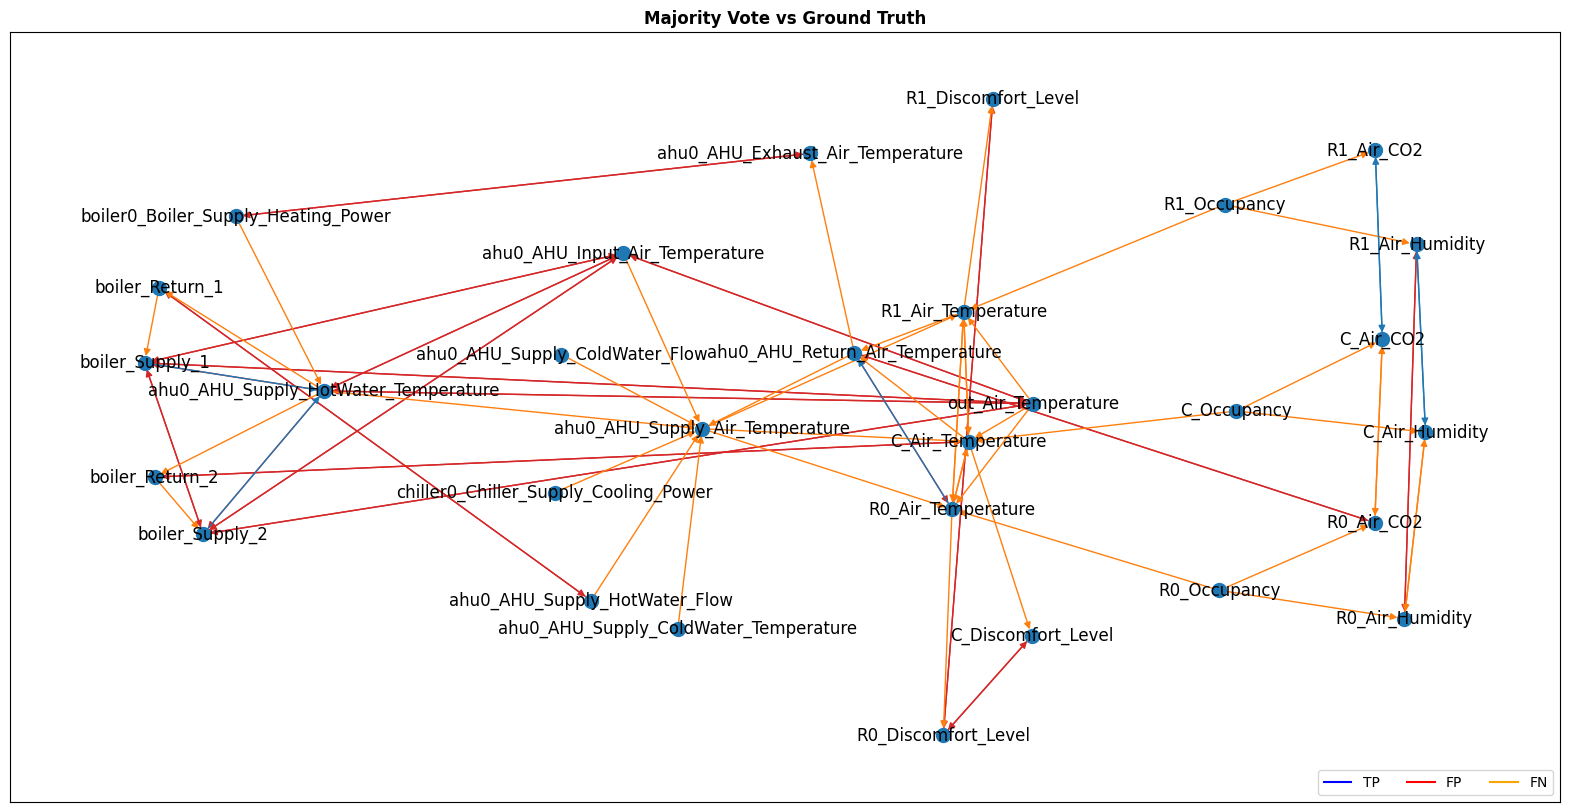

In [284]:
adj_total_mvU=np.where(adj_total/cnt>=0.5, 1, 0)

GMVU = nx.from_numpy_array(adj_total_mvU*adj_total, create_using=nx.DiGraph)
np.save("Graphs/UnclusteredGMV_weighted.npy", GMVU)

adj_total_mvU=np.where(adj_total/cnt>=0.5, 1, 0)

GMVU = nx.from_numpy_array(adj_total_mvU, create_using=nx.DiGraph)
np.save("Graphs/UnclusteredGMV.npy", GMVU)

GMVU = nx.relabel_nodes(GMVU, mapping)
GMVU.name="Majority Vote"

compare_plot(GMVU, GN)
compare(GMVU, GN)

{'name': '1/3 Vote',
 'Density': 0.05517241379310345,
 'Pdensity': 0.05747126436781609,
 'Edges': 48,
 'P': 50,
 'N': 443,
 'TP': 8,
 'FP': 40,
 'FN': 42,
 'TN': 423,
 'TPR': 0.16,
 'TNR': 0.9136069114470843,
 'PPV': 0.16666666666666666,
 'ACC': 0.8401559454191033,
 'F1': 0.16326530612244897}

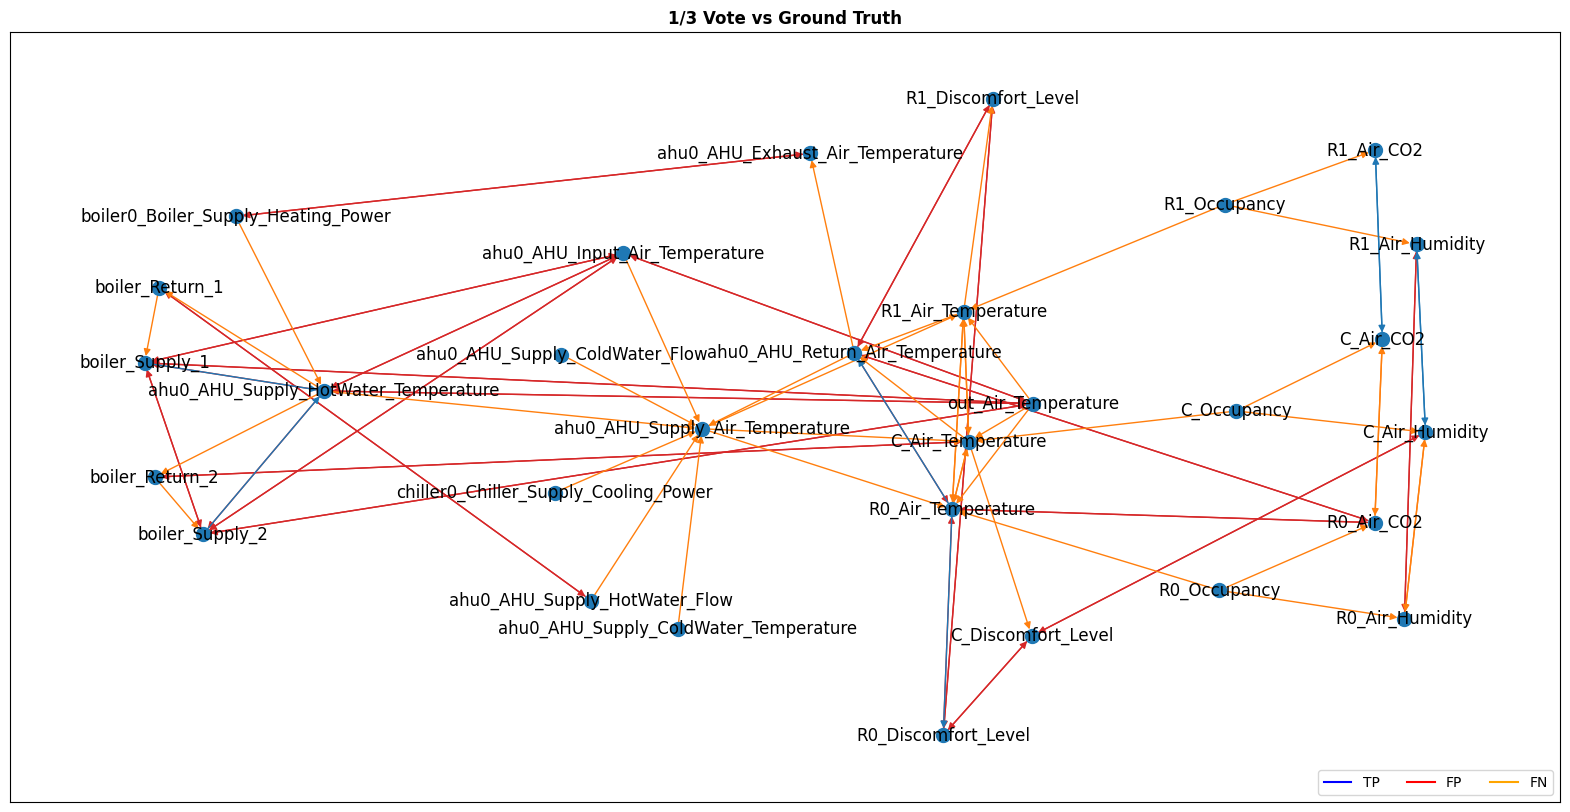

In [285]:
adj_total_mv33U=np.where(adj_total/cnt>=1/3.0, 1, 0)

GMVU33 = nx.from_numpy_array(adj_total_mv33U*adj_total, create_using=nx.DiGraph)
np.save("Graphs/UnclusteredGMV33_weighted.npy", GMVU33)

GMVU33 = nx.from_numpy_array(adj_total_mv33U, create_using=nx.DiGraph)
np.save("Graphs/UnclusteredGMV33.npy", GMVU33)

GMVU33 = nx.relabel_nodes(GMVU33, mapping)
GMVU33.name="1/3 Vote"

compare_plot(GMVU33, GN)
compare(GMVU33, GN)

{'name': 'Any',
 'Density': 0.052873563218390804,
 'Pdensity': 0.05747126436781609,
 'Edges': 46,
 'P': 50,
 'N': 443,
 'TP': 6,
 'FP': 40,
 'FN': 44,
 'TN': 423,
 'TPR': 0.12,
 'TNR': 0.9136069114470843,
 'PPV': 0.13043478260869565,
 'ACC': 0.8362573099415205,
 'F1': 0.125}

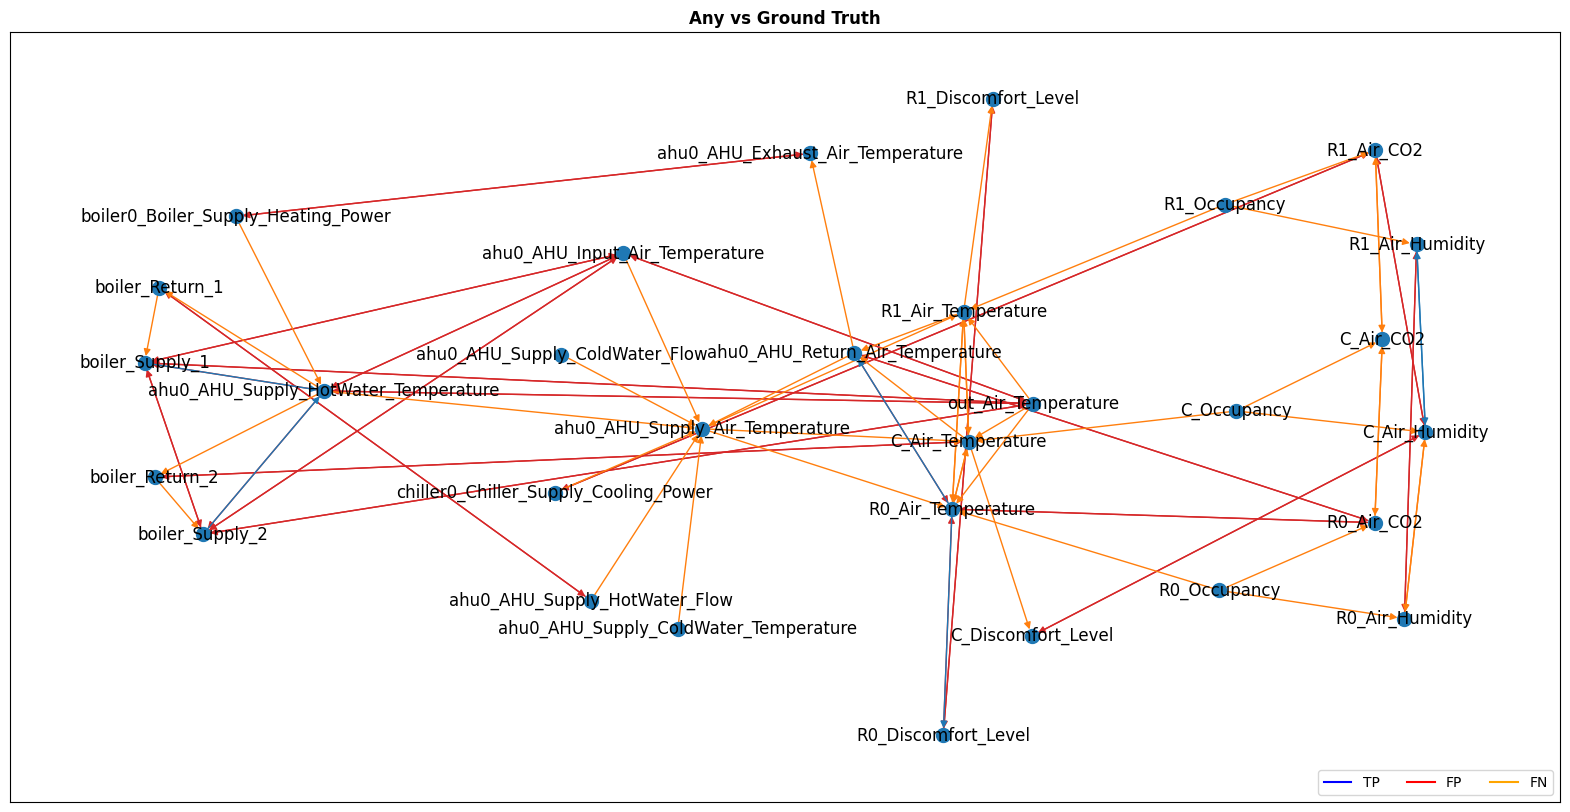

In [286]:
adj_total_anyU=np.where(adj_total>0, 1, 0)

GTAU = nx.from_numpy_array(adj_total_anyU*adj_total, create_using=nx.DiGraph)
np.save("Graphs/UnclusteredGTA_weighted.npy", GTAU)

GTAU = nx.from_numpy_array(adj_total_anyU, create_using=nx.DiGraph)
np.save("Graphs/UnclusteredGTA.npy", GTAU)

GTAU = nx.relabel_nodes(G, mapping)
GTAU.name="Any"

compare_plot(GTAU, GN)
compare(GTAU, GN)

## Animations

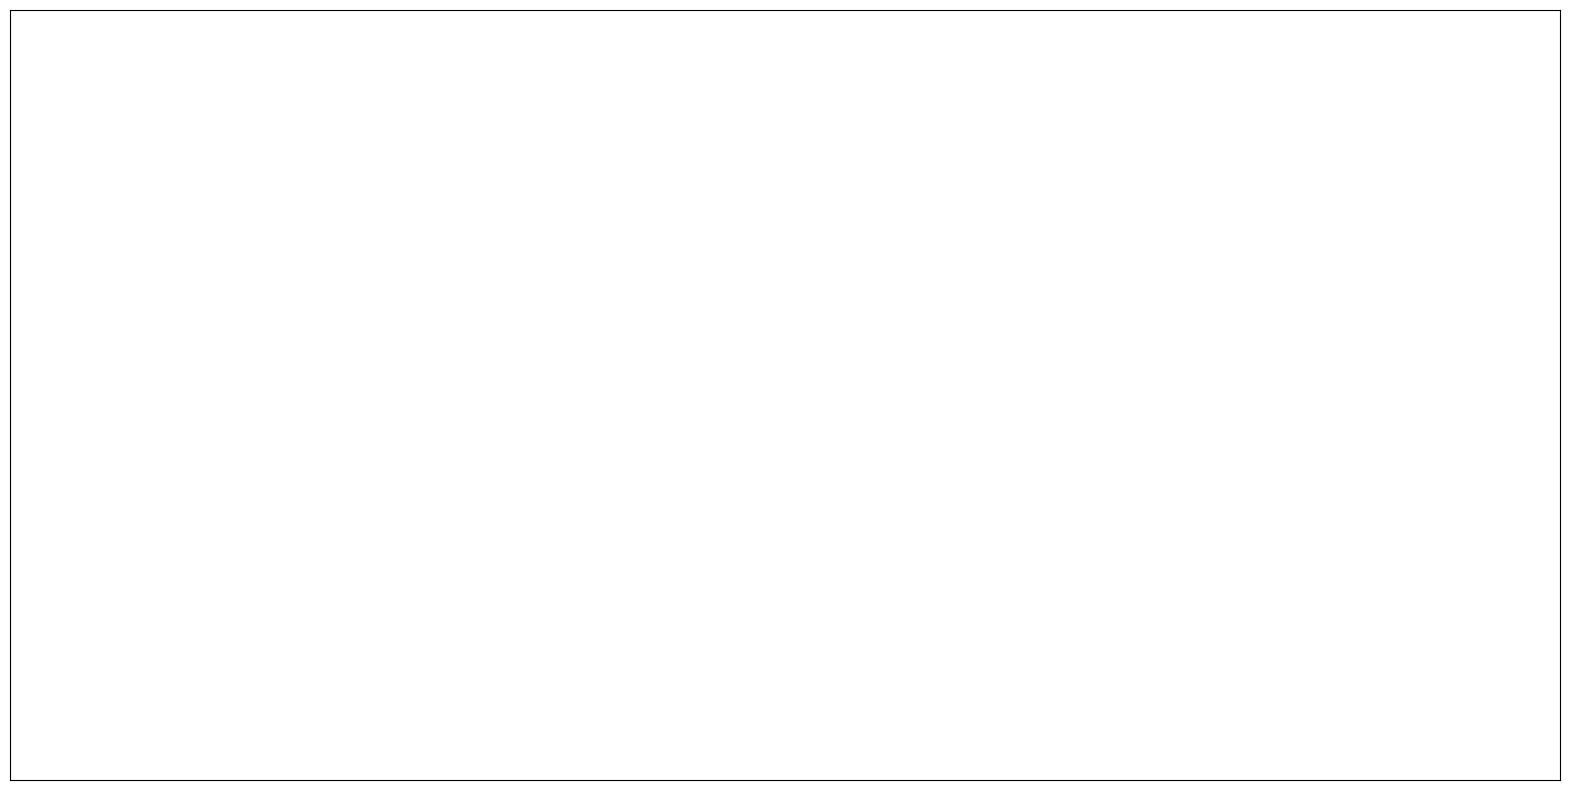

In [287]:
fig, ax = plt.subplots(figsize=(20,10))
ax.legend(handles=[
    Line2D([0], [0], color='red', label='FP'),
    Line2D([0], [0], color='orange', label='FN'),
    Line2D([0], [0], color='blue', label='TP')
], loc='lower right', ncols=3)

def animate_compare_plot_GN(i):
    ax.clear()

    fn=f"Graphs/Clustering/PCMCI+_GPDC_30_144_6_{i}_10_stats.json"
    if os.path.exists(fn):
        G,_=load_graph_stats(fn, f"Clustering Day {i}")
        TP = nx.intersection(G, GN)
        FP = nx.difference(G, GN)
        FN = nx.difference(GN, G)

        ns=200
        nx.draw_networkx_nodes(G, ax=ax, node_size=ns, node_color=[G.nodes[n]['color'] for n in G.nodes], pos=pos)
        nx.draw_networkx_labels(G, ax=ax, pos=pos)
        nx.draw_networkx_edges(FP, ax=ax, node_size=ns, edge_color="tab:red", pos=pos)
        nx.draw_networkx_edges(FN, ax=ax, node_size=ns, edge_color="tab:orange", pos=pos)
        nx.draw_networkx_edges(TP, ax=ax, node_size=ns, edge_color="tab:blue", pos=pos)
        nx.draw_networkx_labels(GN, pos=pos, ax=ax)

        ax.legend(handles=[
            Line2D([0], [0], color='blue', label='TP'),
            Line2D([0], [0], color='red', label='FP'),
            Line2D([0], [0], color='orange', label='FN')
        ], loc='lower right', ncols=3)
        ax.set_title(f"{G.name} vs {GN.name}", fontweight="bold")

anim = animation.FuncAnimation(fig, animate_compare_plot_GN, frames=364, interval=200)#, blit=True
anim.save("Plots/animate_compare_expected.mp4")

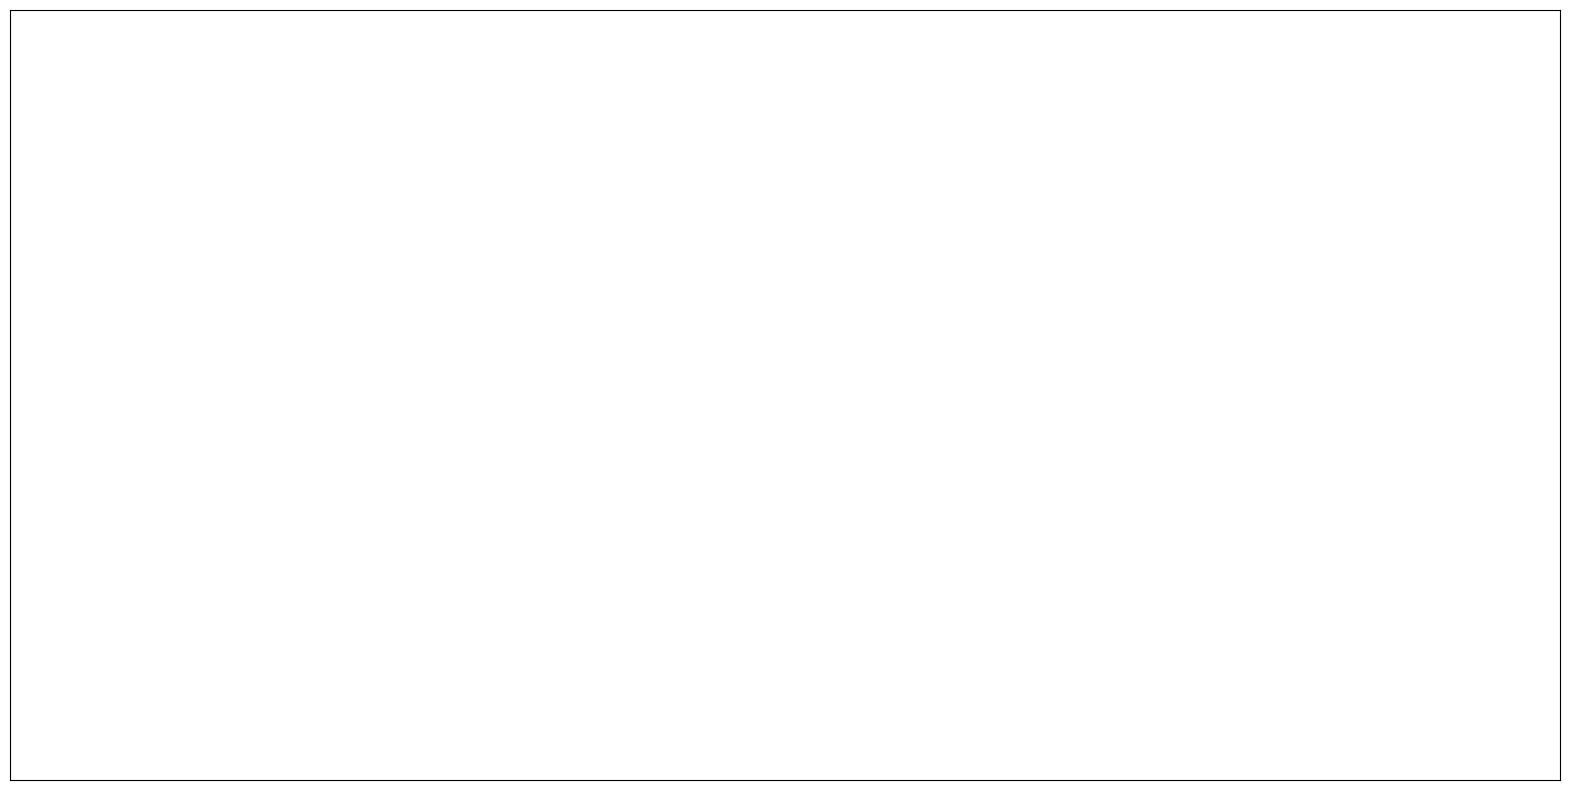

In [288]:
fig, ax = plt.subplots(figsize=(20,10))
ax.legend(handles=[
    Line2D([0], [0], color='red', label='FP'),
    Line2D([0], [0], color='orange', label='FN'),
    Line2D([0], [0], color='blue', label='TP')
], loc='lower right', ncols=3)

def animate_compare_plot_GL(i):
    ax.clear()

    fn0=f"Graphs/Clustering/PCMCI+_GPDC_30_144_6_{i}_10_stats.json"
    fn1=f"Graphs/Clustering/PCMCI+_GPDC_30_144_6_{i+1}_10_stats.json"
    if os.path.exists(fn0) and os.path.exists(fn1):
        G0,_=load_graph_stats(fn0, f"Clustering Day {i}")
        G1,_=load_graph_stats(fn1, f"Clustering Day {i+1}")
        TP = nx.intersection(G1, G0)
        FP = nx.difference(G1, G0)
        FN = nx.difference(G0, G1)

        ns=200
        nx.draw_networkx_nodes(G0, ax=ax, node_size=ns, node_color=[G0.nodes[n]['color'] for n in G0.nodes], pos=pos)
        nx.draw_networkx_labels(G0, ax=ax, pos=pos)
        nx.draw_networkx_edges(GN, ax=ax, node_size=ns, edge_color="tab:gray", alpha=0.3, pos=pos)
        nx.draw_networkx_edges(FN, ax=ax, node_size=ns, edge_color="tab:red", pos=pos)
        nx.draw_networkx_edges(FP, ax=ax, node_size=ns, edge_color="tab:orange", pos=pos)
        nx.draw_networkx_edges(TP, ax=ax, node_size=ns, edge_color="tab:blue", pos=pos)

        ax.legend(handles=[
            Line2D([0], [0], color='gray', alpha=0.3, label='ref'),
            Line2D([0], [0], color='blue', label='same'),
            Line2D([0], [0], color='red', label='del'),
            Line2D([0], [0], color='orange', label='add')
        ], loc='lower right', ncols=4)
        ax.set_title(f"{G0.name} vs {G1.name}", fontweight="bold")

anim = animation.FuncAnimation(fig, animate_compare_plot_GL, frames=363, interval=200)#, blit=True
anim.save("Plots/animate_compare_last.mp4")

## Runtimes

In [289]:
rt=pd.read_csv("runtimes.csv")
rt=rt[rt['period']==144]
rt['total_time']=pd.to_timedelta(rt['total_time'])
rt['1y_time']=365*rt['total_time']

In [290]:
rt

approach   N  period  tau  day  clusters             total_time  \
11   clustering  30     144    6    1        10 0 days 00:08:35.372763   
12   clustering  30     144    6    2        10 0 days 00:07:20.961005   
13   clustering  30     144    6    3        10 0 days 00:10:41.034819   
14   clustering  30     144    6    4        10 0 days 00:08:29.290031   
15   clustering  30     144    6    5        10 0 days 00:09:54.259471   
..          ...  ..     ...  ...  ...       ...                    ...   
444        full  30     144    6   66         1 0 days 00:43:03.085358   
445        full  30     144    6   67         1 0 days 00:46:40.957989   
446        full  30     144    6   68         1 0 days 00:40:10.658756   
447        full  30     144    6   69         1 0 days 00:40:32.898617   
448        full  30     144    6   70         1 0 days 00:44:33.635023   

                                                file                 1y_time  
11   Graphs/Clustering/PCMCI+_GPDC_30_144_6_1_10.npy  2 days 04:15:11.058495  
12   Graphs/Clustering/PCMCI+_GPDC_30_144_6_2_10.npy  1 days 20:42:30.766825  
13   Graphs/Clustering/PCMCI+_GPDC_30_144_6_3_10.npy  2 days 16:59:37.708935  
14   Graphs/Clustering/PCMCI+_GPDC_30_144_6_4_10.npy  2 days 03:38:10.861315  
15   Graphs/Clustering/PCMCI+_GPDC_30_144_6_5_10.npy  2 days 12:15:04.706915  
..                                               ...                     ...  
444               Graphs/PCMCI+_GPDC_30_144_6_66.npy 10 days 21:53:46.155670  
445               Graphs/PCMCI+_GPDC_30_144_6_67.npy 11 days 19:59:09.665985  
446               Graphs/PCMCI+_GPDC_30_144_6_68.npy 10 days 04:24:50.445940  
447               Graphs/PCMCI+_GPDC_30_144_6_69.npy 10 days 06:40:07.995205  
448               Graphs/PCMCI+_GPDC_30_144_6_70.npy 11 days 07:04:36.783395  

[438 rows x 9 columns]

In [291]:
rt.describe()

N  period    tau         day    clusters  \
count  438.0   438.0  438.0  438.000000  438.000000   
mean    30.0   144.0    6.0  157.484018    8.561644   
std      0.0     0.0    0.0  111.025193    3.301700   
min     30.0   144.0    6.0    1.000000    1.000000   
25%     30.0   144.0    6.0   53.000000   10.000000   
50%     30.0   144.0    6.0  145.500000   10.000000   
75%     30.0   144.0    6.0  254.750000   10.000000   
max     30.0   144.0    6.0  364.000000   10.000000   

                      total_time                    1y_time  
count                        438                        438  
mean   0 days 00:14:22.701720244  3 days 15:28:06.127889166  
std    0 days 00:15:36.582732954  3 days 22:57:32.697528478  
min       0 days 00:04:16.355273     1 days 01:59:29.674645  
25%    0 days 00:06:48.202543750  1 days 17:23:13.928468750  
50%       0 days 00:08:11.242346     2 days 01:48:23.456290  
75%    0 days 00:10:46.668195500  2 days 17:33:53.891357500  
max       0 days 02:19:46.121194    35 days 10:15:34.235810

In [292]:
rtFull=rt[rt['approach']=='full']
rtFull.describe()

N  period   tau        day  clusters                 total_time  \
count  70.0    70.0  70.0  70.000000      70.0                         70   
mean   30.0   144.0   6.0  35.500000       1.0  0 days 00:46:57.477653285   
std     0.0     0.0   0.0  20.351085       0.0  0 days 00:15:08.334975132   
min    30.0   144.0   6.0   1.000000       1.0     0 days 00:31:08.848913   
25%    30.0   144.0   6.0  18.250000       1.0  0 days 00:39:26.613543750   
50%    30.0   144.0   6.0  35.500000       1.0  0 days 00:43:45.516247500   
75%    30.0   144.0   6.0  52.750000       1.0  0 days 00:47:44.293064500   
max    30.0   144.0   6.0  70.000000       1.0     0 days 02:19:46.121194   

                          1y_time  
count                          70  
mean   11 days 21:39:39.343449285  
std     3 days 20:05:42.265923326  
min        7 days 21:28:49.853245  
25%     9 days 23:56:53.943468750  
50%    11 days 02:11:53.430337500  
75%    12 days 02:24:26.968542500  
max       35 days 10:15:34.235810

In [293]:
rtClust=rt[rt['approach']=='clustering']
rtClust.describe()

N  period    tau         day  clusters                 total_time  \
count  368.0   368.0  368.0  368.000000     368.0                        368   
mean    30.0   144.0    6.0  180.687500      10.0  0 days 00:08:10.869341676   
std      0.0     0.0    0.0  105.933055       0.0  0 days 00:02:28.020181080   
min     30.0   144.0    6.0    1.000000      10.0     0 days 00:04:16.355273   
25%     30.0   144.0    6.0   87.750000      10.0  0 days 00:06:33.619704250   
50%     30.0   144.0    6.0  180.500000      10.0  0 days 00:07:50.607852500   
75%     30.0   144.0    6.0  272.250000      10.0     0 days 00:09:15.554728   
max     30.0   144.0    6.0  364.000000      10.0     0 days 00:24:14.048041   

                         1y_time  
count                        368  
mean   2 days 01:46:07.309711970  
std    0 days 15:00:27.366094494  
min       1 days 01:59:29.674645  
25%    1 days 15:54:31.192051250  
50%    1 days 23:42:51.866162500  
75%       2 days 08:19:37.475720  
max       6 days 03:25:27.534965

In [294]:
pd.to_timedelta("11 days 23:45:15.926900625")/pd.to_timedelta("2 days 01:46:07.309711970")

5.78183558466088

In [295]:
pd.to_timedelta("2 days 01:46:07.309711970").total_seconds()/60/60

49.76869714194445

In [296]:
pd.to_timedelta("11 days 23:45:15.926900625").total_seconds()/60/60

287.75442413888885

In [297]:
fac=pd.to_timedelta("35:03:00").total_seconds()/pd.to_timedelta("02:25:00").total_seconds()

In [298]:
pd.to_timedelta("02:25:00").total_seconds()/60/60*pd.to_timedelta("1540:00:00").total_seconds()/pd.to_timedelta("35:03:00").total_seconds()

106.18164526866381

<AxesSubplot: >

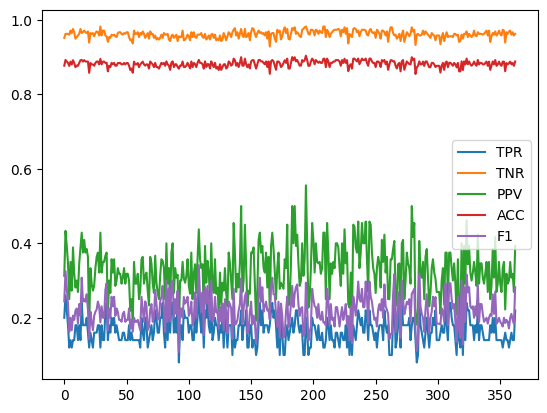

In [299]:
compGNdf[['TPR',"TNR","PPV","ACC","F1"]].plot()

<AxesSubplot: >

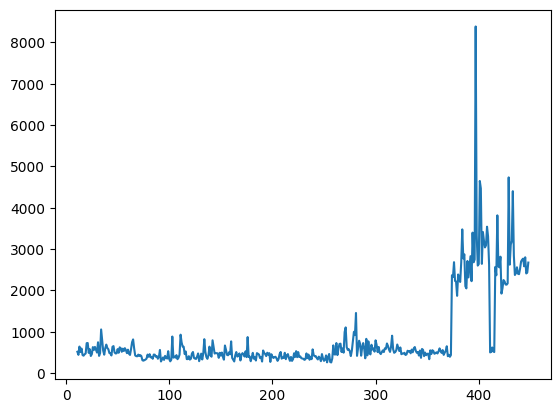

In [300]:
rt['total_time'].dt.total_seconds().plot()

In [386]:
import plotly.express as px

In [452]:
sdf=pd.read_csv('sealice_performance.csv')
sdf

Approach      RMSE  45 min MSE   Delta D2.5  Delta D1
0             Distance TGCN  1.173979    1.254009                    NaN
1      Spatiotemporal CTGCN  1.157447    1.246562  0.083695122  0.014082
2      Spatiotemporal CTGCN  1.163376    1.248850  0.079001368  0.009032
3      Spatiotemporal CTGCN  1.163608    1.248849  0.078817703  0.008834
4      Spatiotemporal CTGCN  1.144340    1.234735  0.094071414  0.025247
5      Spatiotemporal CTGCN  1.155383    1.244843  0.085329109  0.015840
6      Spatiotemporal CTGCN  1.142946    1.233020  0.095174989  0.026434
7      Spatiotemporal CTGCN  1.166557    1.247270  0.076483096  0.006322
8      Spatiotemporal CTGCN  1.154809    1.242386  0.085783522  0.016329
9      Spatiotemporal CTGCN  1.136849    1.230072  0.100001742  0.031627
10     Spatiotemporal CTGCN  1.150042    1.239467  0.089557367  0.020390
11     Spatiotemporal CTGCN  1.138868    1.228616  0.098403379  0.029908
12  Spatiotemporal MT CTGCN  1.132168    1.227729  0.103707504  0.035615

In [453]:
sdf.groupby("Approach").mean()

RMSE  45 min MSE  Delta D1
Approach                                               
Distance TGCN            1.173979    1.254009       NaN
Spatiotemporal CTGCN     1.152202    1.240425  0.018550
Spatiotemporal MT CTGCN  1.132168    1.227729  0.035615

In [454]:
fig=px.box(sdf, x="Approach",y="RMSE", color='Approach')
fig.update_layout(
  #showlegend=False,
  margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
  legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
)
)
fig.update_xaxes(showticklabels=False)
fig.show()
fig.write_image('Plots/Sealice.pdf', width=500, height=300)

In [455]:
pem=pd.read_csv('pemsd7_performance.csv')
#pem


In [456]:
pem.groupby("Approach").mean()

Overall MAE  45 min MAE      RMSE  45 min MSE
Approach                                                                 
Distance TGCN                  1.190620    1.973200  9.643457   10.215300
STGCN (1st order; Yu 2018)     0.000000    0.000000  7.030000    7.030000
STGCN (Cheb; Yu 2018)          0.000000    0.000000  6.770000    6.770000
Spatiotemporal CTGCN           1.320729    2.199751  6.413470    7.974815
Spatiotemporal MT CTGCN        1.748857    2.702812  5.884113    7.767046
Temporal CTGCN                 1.158632    2.083610  6.733874    8.148780
Temporal MT CTGCN              1.706770    2.552243  6.173614    7.929363

In [457]:
fig=px.box(pem, x="Approach",y="RMSE", color='Approach')
fig.update_layout(
  #showlegend=False,
  margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
  legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
)
)
fig.update_xaxes(showticklabels=False)
fig.show()
fig.write_image('Plots/PEMSD7.pdf', width=500, height=300)

In [446]:
pem=pd.read_csv('building_predictions.csv')
#pem

In [447]:
fig=px.box(pem, x="Approach",y="RMSE", color='Approach')
fig.update_layout(
  #showlegend=False,
  margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
  legend=dict(
    yanchor="top",
    y=-0.1,
    xanchor="center",
    x=0.5,
    orientation= 'h'
)
)
fig.update_xaxes(showticklabels=False)
fig.show()
fig.write_image('Plots/Building.pdf', width=500, height=410)